In [5]:
%matplotlib notebook

In [6]:
%load_ext autoreload
%autoreload 2
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:96% !important; }</style>"))

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread
import torch.nn as nn
import numpy as np
from skimage import img_as_ubyte
import imageio
import json
import cv2
import time
from PIL import Image
from pytorch3d.loss import (
    mesh_laplacian_smoothing, 
    mesh_normal_consistency,
)
from torch.optim.lr_scheduler import ReduceLROnPlateau
import Utility
import torch.nn.functional as F

from tqdm import tqdm_notebook
# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes, load_obj, load_ply
import math
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures, join_meshes_as_batch
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    SfMPerspectiveCameras,
    SfMOrthographicCameras,
    PointLights, 
    BlendParams,
    DirectionalLights,
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    look_at_rotation,
    HardFlatShader
)

# add path for demo utils functions 
import sys
import os
import glob
sys.path.append(os.path.abspath(''))

print(torch.version.cuda)
from datetime import datetime

SMPLSH_Dir = r'..\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch

from os.path import join
import pyvista as pv
import Logger

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


10.1


In [3]:
import importlib
importlib.reload(Utility)
from Utility import *

In [4]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.005
        s.terminateLoss = 200
        s.plotStep = 10
        s.numCams = 16
        s.imgSize = 2160
        
        s.lpSmootherW = 0.1
        s.normalSmootherW = 0.1

        
class Renderer:
    def __init__(s, cfg = RenderingCfg):
        s.cfg = cfg
        # blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
        s.blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

        # Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
        # -z direction. 
        s.lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])
#         cameras = OpenGLPerspectiveCameras(device=device)
        # Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
        # interpolate the texture uv coordinates for each vertex, sample from a texture image and 
        # apply the Phong lighting model
        
        if cfg.blurRange!= 0:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= np.log(1. / cfg.blurRange - 1.) * s.blend_params.sigma, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
        else:
            s.raster_settings = RasterizationSettings(
                image_size=cfg.imgSize, 
                blur_radius= 0, 
                faces_per_pixel=cfg.faces_per_pixel, 
                bin_size=0
            )
            
        s.rasterizer=MeshRasterizer(
                cameras=None, 
                raster_settings=s.raster_settings
            )
        if cfg.blurRange!= 0:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )
        else:
            s.renderer = MeshRenderer(
                rasterizer = s.rasterizer,
            #     shader=SoftPhongShader(
            #         device=device, 
            #         cameras=cameras,
            #         lights=lights,
            #         blend_params=blend_params
            #     )
                shader=SoftSilhouetteShader(
                    blend_params=s.blend_params
                    # device=device, 
                    # cameras=cameras,
                    # lights=lights
                )
            )

In [7]:
cfg = RenderingCfg()
# cfg.sigma = 1e-3
cfg.noiseLevel = 0.1
# cfg.blurRange = 1e-1
# cfg.sigma = 1e-4
# cfg.sigma = 1e-5

# cfg.blurRange = 1e-4

# cfg.sigma = 1e-6
# cfg.blurRange = 1e-5

cfg.sigma = 1e-7
cfg.blurRange = 1e-7

cfg.plotStep = 10
cfg.numCams = 16
# cfg.learningRate = 1
# cfg.learningRate = 0.1
cfg.learningRate = 1

cfg.normalShiftLevel = 10
# cfg.faces_per_pixel = 14
# cfg.faces_per_pixel = 30
cfg.faces_per_pixel = 15

# cfg.imgSize = 2160   
cfg.imgSize = 1080
device = torch.device("cuda:0")
cfg.terminateLoss = 0.1

cfg.lpSmootherW = 1
# cfg.normalSmootherW = 0.1
cfg.normalSmootherW = 1



renderSynth = Renderer(cfg)

cfgRef = RenderingCfg()
cfgRef.faces_per_pixel = 1
cfgRef.blurRange = 0
cfgRef.sigma = 0
cfgRef.imgSize = 1080
renderRef = Renderer(cfgRef)

In [8]:
camParamF = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\CameraParams\cam_params.json'
imageFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Images\03052\Undist'
modelFile = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Models\03052.obj'

outFolder = r'F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\SyntheticSilhouette'
smplshExampleMeshFile = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SMPLSH.obj'

In [9]:

actual_img_shape = (2160, 4000)
cam_params, cams_torch = load_cameras(camParamF, device, actual_img_shape)
print(len(cam_params), ':', cam_params[0].keys())
print(cams_torch.keys())

smplshExampleMesh = pv.PolyData(smplshExampleMeshFile)

actual_img_shape: (2160, 4000)
16 : dict_keys(['K', 'dist', 'R', 'T', 'fx', 'fy', 'cx', 'cy'])
dict_keys(['R', 'T', 'fl', 'pp'])


In [10]:
cams_torch['fl']

tensor([[1.7616, 1.7604],
        [1.7548, 1.7537],
        [1.7569, 1.7558],
        [1.7568, 1.7558],
        [1.7532, 1.7523],
        [1.7562, 1.7548],
        [1.7579, 1.7567],
        [1.7568, 1.7555],
        [1.7565, 1.7552],
        [1.7648, 1.7633],
        [1.7565, 1.7554],
        [1.7601, 1.7592],
        [1.7568, 1.7557],
        [1.7585, 1.7573],
        [1.7578, 1.7566],
        [1.7564, 1.7553]])

In [11]:
cams = init_camera_batches(cams_torch, device)

In [12]:
verts, faces, aux = load_obj(modelFile)
verts = verts.to(device)
faces_idx = faces.verts_idx.to(device)

nVerts = verts.shape[0]

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\pytorch3d-0.2.0-py3.6-win-amd64.egg\pytorch3d\io\obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


In [13]:
aux.normals.shape

torch.Size([6750, 3])

In [14]:
nNormals = normalizeNormals(aux.normals).to(device)

torch.Size([6750])


In [15]:
normalShiftRef = torch.tensor(np.full((nVerts,1), cfg.normalShiftLevel), dtype=torch.float32, device=device)

In [16]:
nNormals

tensor([[ 0.7431, -0.5174,  0.4244],
        [ 0.6826, -0.5591,  0.4706],
        [ 0.8415, -0.3859,  0.3782],
        ...,
        [ 0.3730, -0.8021,  0.4664],
        [ 0.4670, -0.6423, -0.6077],
        [-0.9316, -0.3278, -0.1569]], device='cuda:0')

In [17]:
modifiedVertsRef = verts + normalShiftRef * nNormals
meshRef = Meshes(
                verts=[modifiedVertsRef],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )

In [18]:
def visualize2DResults(images, backGroundImages=None, outImgFile=None, rows = 2, pytorch3DImg=True, sizeInInches = 2):
    lossVal = 0
    numCams = len(images)
    numCols = int(numCams / rows)
    fig, axs = plt.subplots(rows, numCols)
    fig.set_size_inches(numCols*sizeInInches, rows*sizeInInches)
    with torch.no_grad():
        for iRow in range(rows):
            for iCol in range(numCols):
                iCam = rows* iRow + iCol
                if pytorch3DImg:
                    imgAlpha = images[iCam][0,...,3]
                else:
                    imgAlpha = images[iCam]
                    
                if backGroundImages is not None:
                    img = np.copy(backGroundImages[iCam])
#                     fgMask = np.logical_not(np.where())
                    for iChannel in range(3):
                        img[..., iChannel] = np.where(imgAlpha, imgAlpha, backGroundImages[iCam][...,iChannel])
                    imgAlpha = img
                    
                imgAlpha = cv2.flip(imgAlpha, -1)
                
                axs[iRow, iCol].imshow(imgAlpha, vmin=0.0, vmax=1.0)
                axs[iRow, iCol].axis('off')

        if outImgFile is not None:
            fig.savefig(outImgFile, dpi=512, transparent=True, bbox_inches='tight', pad_inches=0)

In [19]:
normalShift = torch.tensor(np.full((nVerts,1), 0), dtype=torch.float32, requires_grad = True, device=device)

In [20]:
modifiedVerts = verts + normalShift * nNormals
mesh = Meshes(
                verts=[modifiedVerts.to(device)],   
                faces=[faces_idx.to(device)], 
#                 textures=textures.to(device)
            )

In [21]:
modifiedVerts.requires_grad

True

In [22]:
expName = 'Sig_' + str(cfg.sigma) + '_BR' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) \
+ '_NCams' + str(cfg.numCams)+ 'ImS' + str(cfg.imgSize) + "_LR" + str(cfg.learningRate) + "_LW" + str(cfg.lpSmootherW) + "_NW" + str(cfg.normalSmootherW)

outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump({"CfgSynth":cfg.__dict__, "CfgRef":cfgRef.__dict__,}, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

outFolderMesh = join(outFolderForExperiment, 'Mesh')
os.makedirs(outFolderMesh, exist_ok=True)

F:\WorkingCopy2\2020_05_31_DifferentiableRendererRealData\Output\SyntheticSilhouette\Sig_1e-07_BR1e-07_Fpp15_NCams16ImS1080_LR1_LW1_NW1


<IPython.core.display.Javascript object>


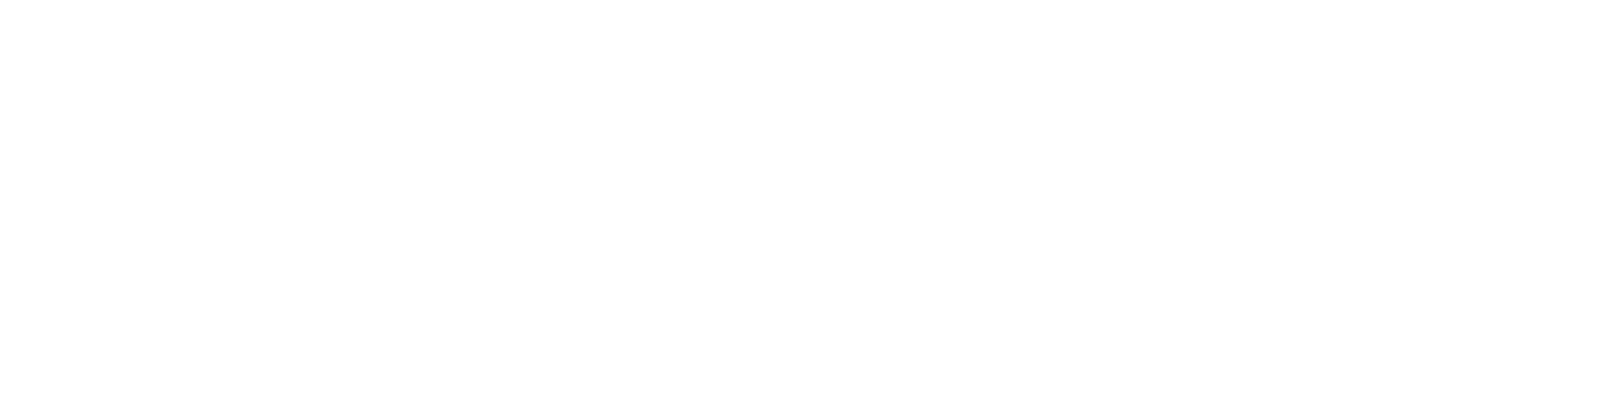

In [23]:
imagesRef = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderRef.renderer(meshRef,  cameras=cams[iCam]).cpu().detach().numpy()
        image_cur[np.where(image_cur)] = 1        
        imagesRef.append(image_cur)
visualize2DResults(imagesRef, outImgFile = join(outFolderForExperiment, 'Target.png'))

<IPython.core.display.Javascript object>


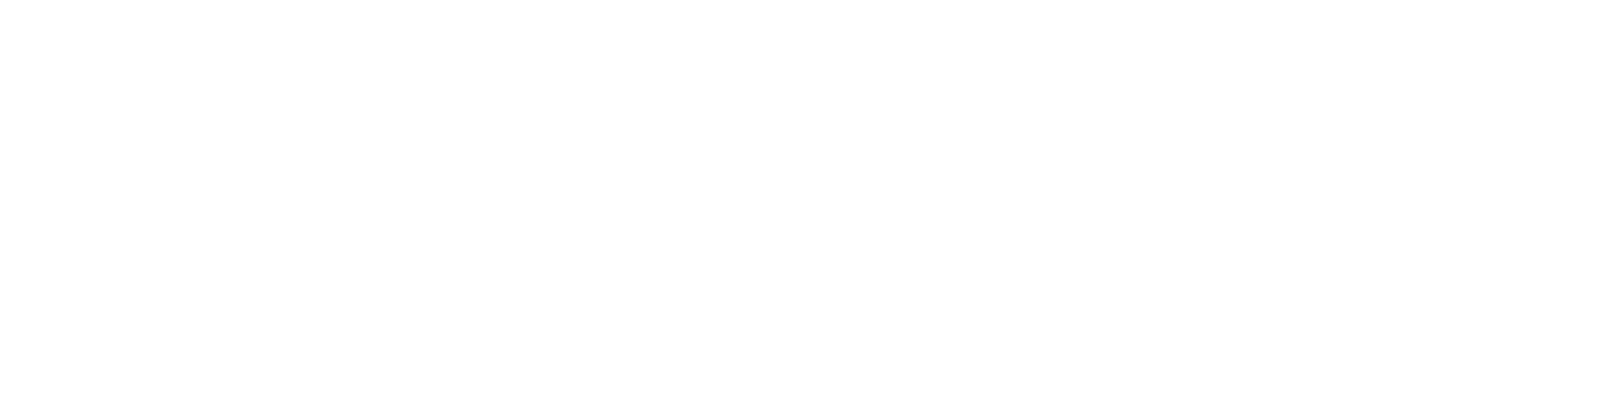

Before release: active_bytes.all.current: 21.490688 MB
After release: active_bytes.all.current: 21.490688 MB


In [24]:
images = []
with torch.no_grad():
    for iCam in range(len(cams)):
        image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
        images.append(image_cur.cpu().detach().numpy())
visualize2DResults(images)
showCudaMemUsage(device)

In [25]:
diffImages = []
loss = 0
for iCam in range(len(cams)):
    imgDiff = np.abs(images[iCam] - imagesRef[iCam])
    diffImages.append(imgDiff)
    
    loss += 1 -np.sum(np.abs(images[iCam][..., 3] * imagesRef[iCam][..., 3])) / np.sum(np.abs(imagesRef[iCam][..., 3] + images[iCam][..., 3] - imagesRef[iCam][..., 3] * images[iCam][..., 3]))

In [26]:
print("mesh_laplacian_smoothing", mesh_laplacian_smoothing(mesh))
print("mesh_normal_consistency", mesh_normal_consistency(mesh))

mesh_laplacian_smoothing tensor(2.6368, device='cuda:0')
mesh_normal_consistency tensor(0.0479, device='cuda:0')


In [27]:
a = np.array([[2,2], [2,2]])
print(np.linalg.norm(a.flatten(), ord=1))

8.0


<IPython.core.display.Javascript object>


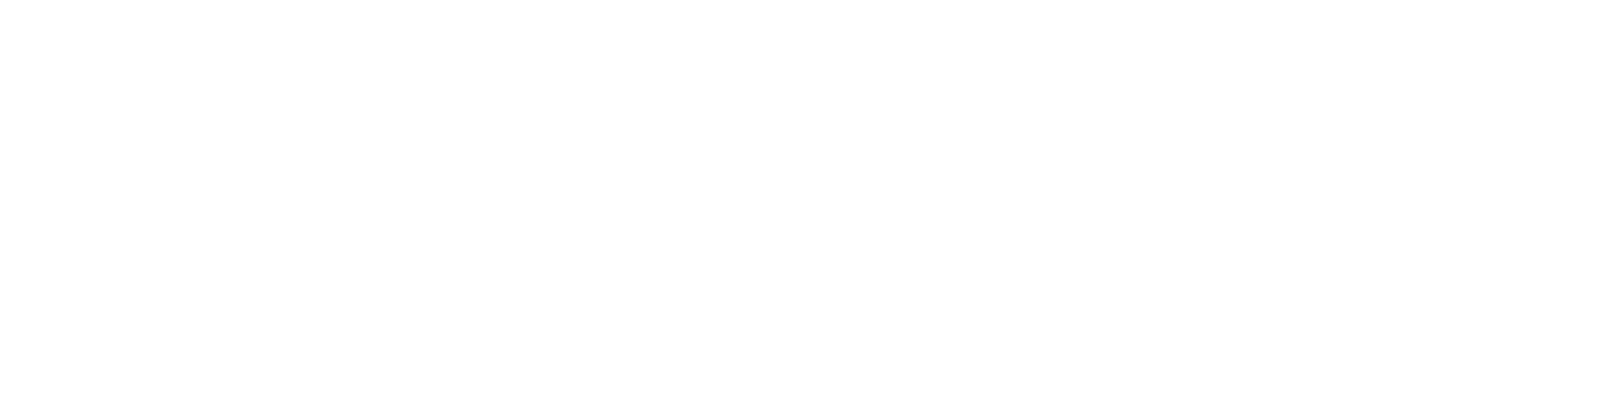

In [28]:
visualize2DResults(diffImages)

In [29]:
# with torch.no_grad():
#     loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
# print('Inital loss:', loss)
poses = []
losses = []

# cfg.learningRate = 0.05
# cfg.learningRate = 0.1
cfg.plotStep = 5
# cfg.learningRate = 3

In [30]:
optimizer = torch.optim.Adam([normalShift], lr=cfg.learningRate)

logFile = join(outFolderForExperiment, 'Logs.txt')
logger = Logger.configLogger(logFile)

In [31]:
torch.cuda.empty_cache()
showCudaMemUsage(device)


Before release: active_bytes.all.current: 23.247872 MB
After release: active_bytes.all.current: 23.247872 MB


In [32]:
cams

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


2020-06-04 00:51:43,130 logger INFO loss 4.63, 3D Dis:  10.00mm, shiftDiff: 66158.515625, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


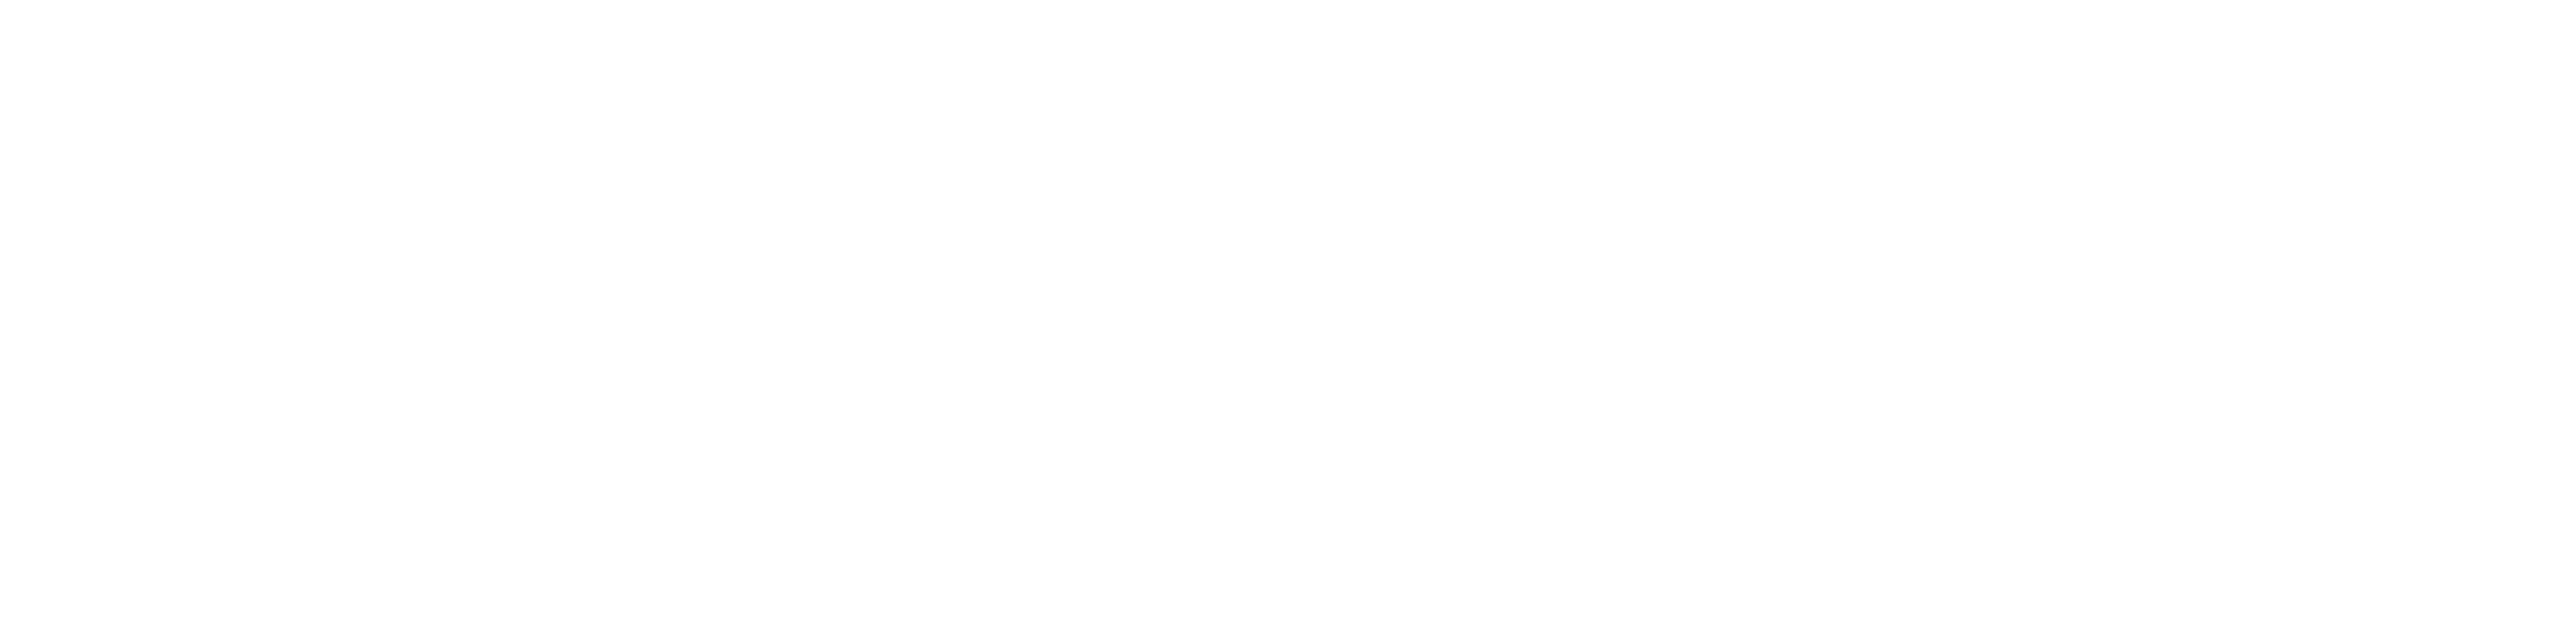

2020-06-04 00:52:07,586 logger INFO loss 4.52, 3D Dis:  9.80mm, shiftDiff: 64749.445312, MemUsed:50.86
2020-06-04 00:52:13,799 logger INFO loss 4.31, 3D Dis:  9.59mm, shiftDiff: 63250.789062, MemUsed:50.86
2020-06-04 00:52:20,168 logger INFO loss 4.14, 3D Dis:  9.37mm, shiftDiff: 61625.023438, MemUsed:50.86
2020-06-04 00:52:26,505 logger INFO loss 4.02, 3D Dis:  9.13mm, shiftDiff: 59893.808594, MemUsed:50.86
2020-06-04 00:52:32,949 logger INFO loss 3.88, 3D Dis:  8.87mm, shiftDiff: 58076.171875, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


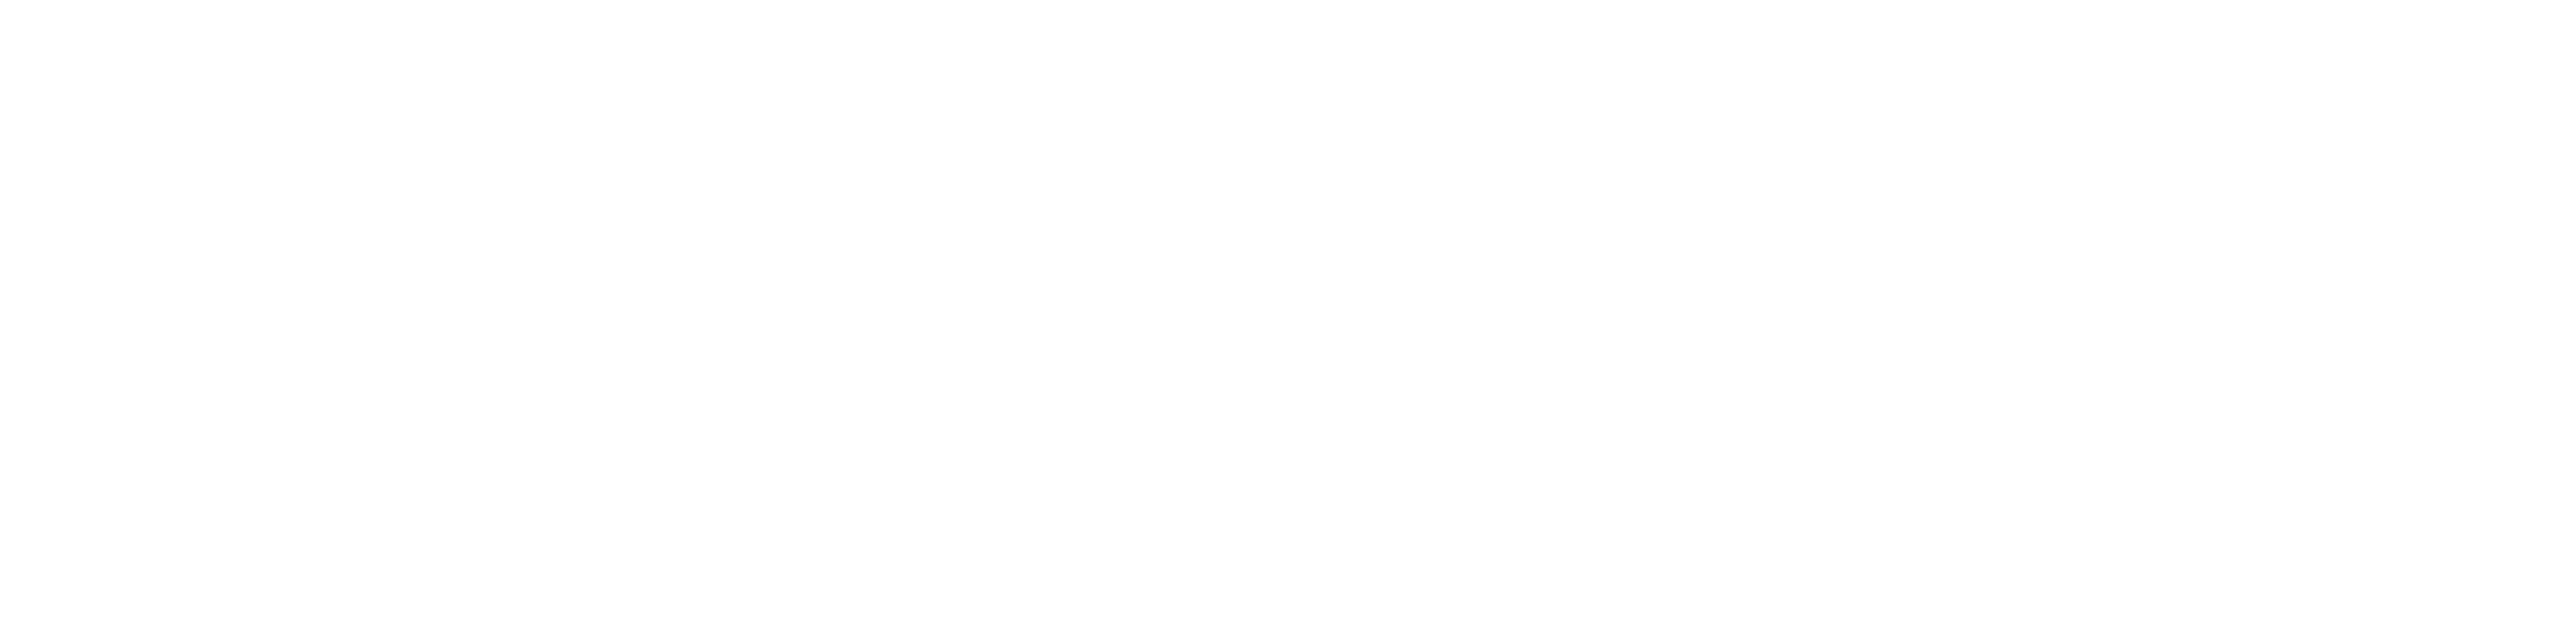

2020-06-04 00:52:57,430 logger INFO loss 3.73, 3D Dis:  8.60mm, shiftDiff: 56190.132812, MemUsed:50.86
2020-06-04 00:53:03,807 logger INFO loss 3.59, 3D Dis:  8.32mm, shiftDiff: 54263.453125, MemUsed:50.86
2020-06-04 00:53:10,219 logger INFO loss 3.46, 3D Dis:  8.04mm, shiftDiff: 52313.289062, MemUsed:50.86
2020-06-04 00:53:16,742 logger INFO loss 3.33, 3D Dis:  7.75mm, shiftDiff: 50360.820312, MemUsed:50.86
2020-06-04 00:53:23,131 logger INFO loss 3.24, 3D Dis:  7.46mm, shiftDiff: 49462.804688, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


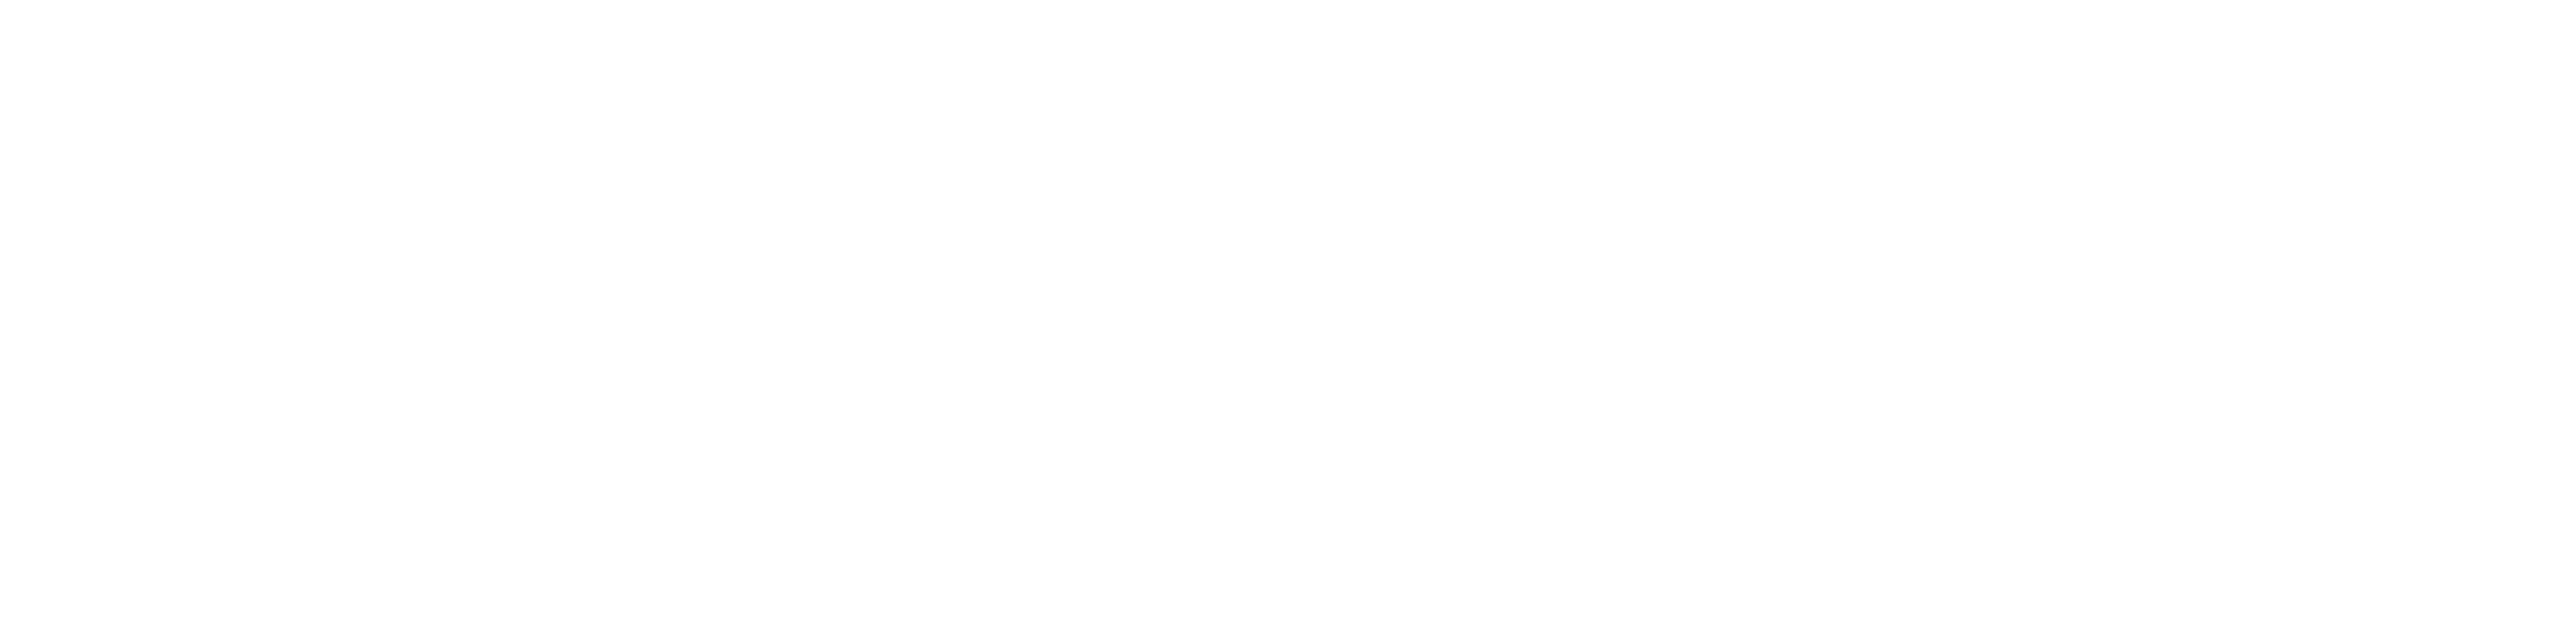

2020-06-04 00:53:47,700 logger INFO loss 3.26, 3D Dis:  7.33mm, shiftDiff: 48886.156250, MemUsed:50.86
2020-06-04 00:53:53,908 logger INFO loss 3.29, 3D Dis:  7.24mm, shiftDiff: 48246.953125, MemUsed:50.86
2020-06-04 00:54:00,313 logger INFO loss 3.29, 3D Dis:  7.15mm, shiftDiff: 47534.359375, MemUsed:50.86
2020-06-04 00:54:06,663 logger INFO loss 3.27, 3D Dis:  7.04mm, shiftDiff: 46795.609375, MemUsed:50.86
2020-06-04 00:54:13,153 logger INFO loss 3.23, 3D Dis:  6.93mm, shiftDiff: 46082.859375, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


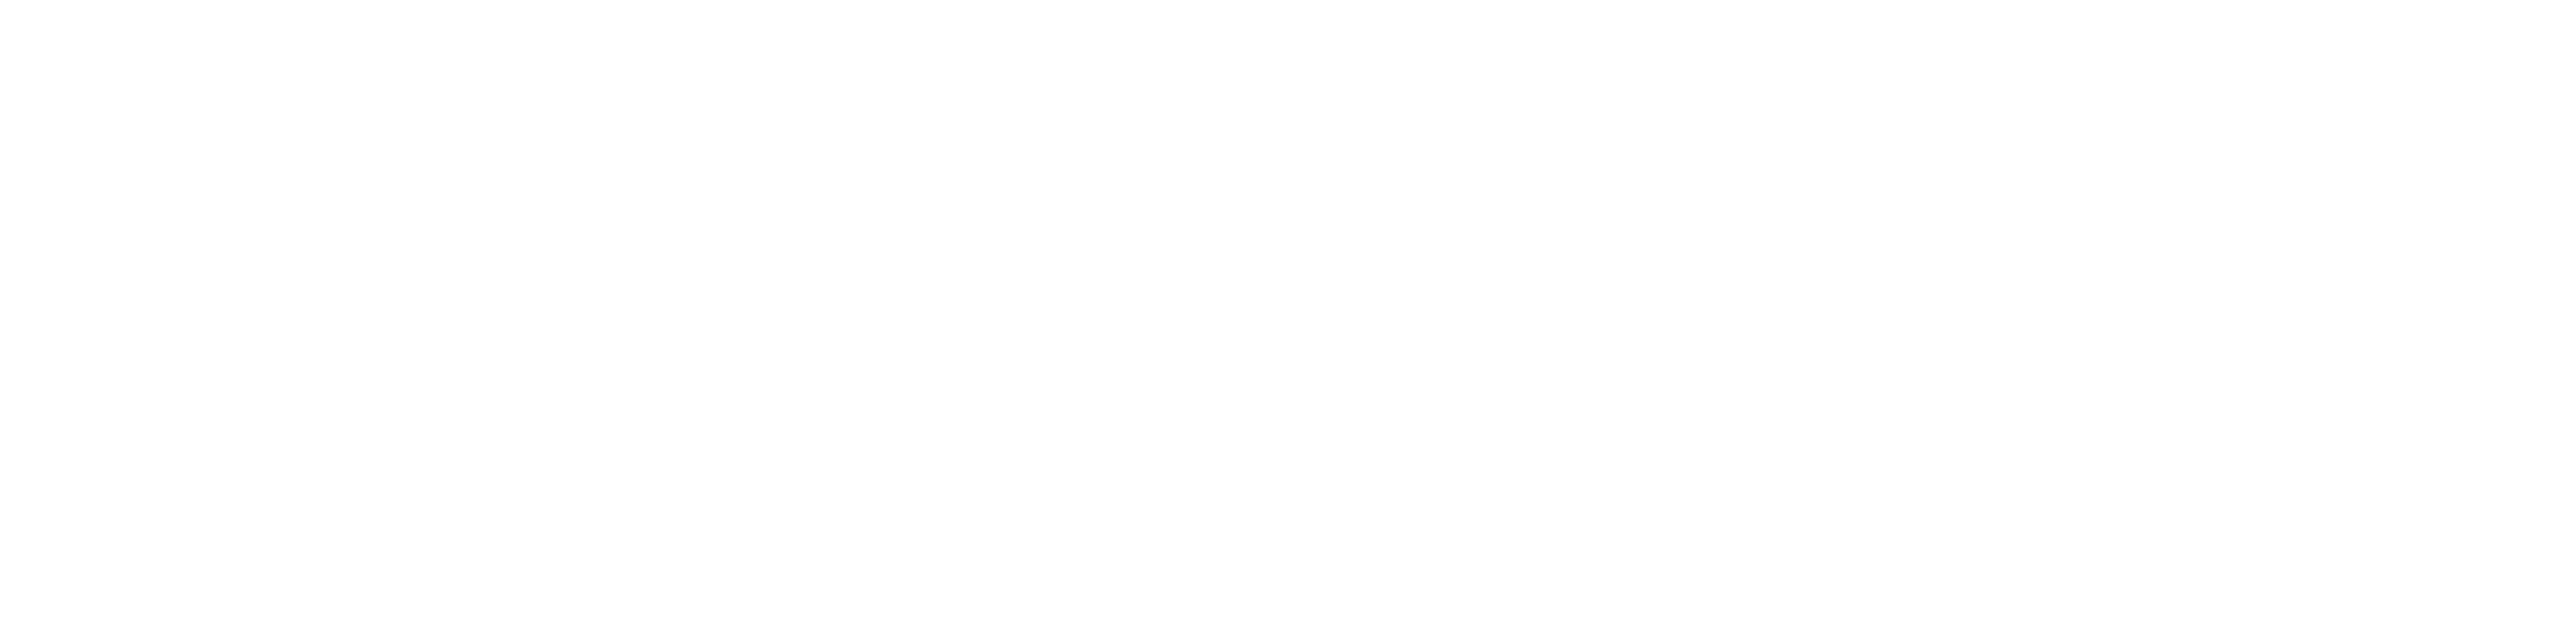

2020-06-04 00:54:37,768 logger INFO loss 3.19, 3D Dis:  6.83mm, shiftDiff: 45435.562500, MemUsed:50.86
2020-06-04 00:54:44,115 logger INFO loss 3.16, 3D Dis:  6.73mm, shiftDiff: 44891.433594, MemUsed:50.86
2020-06-04 00:54:50,467 logger INFO loss 3.13, 3D Dis:  6.65mm, shiftDiff: 44437.414062, MemUsed:50.86
2020-06-04 00:54:56,975 logger INFO loss 3.11, 3D Dis:  6.58mm, shiftDiff: 44038.609375, MemUsed:50.86
2020-06-04 00:55:03,349 logger INFO loss 3.10, 3D Dis:  6.52mm, shiftDiff: 43662.738281, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


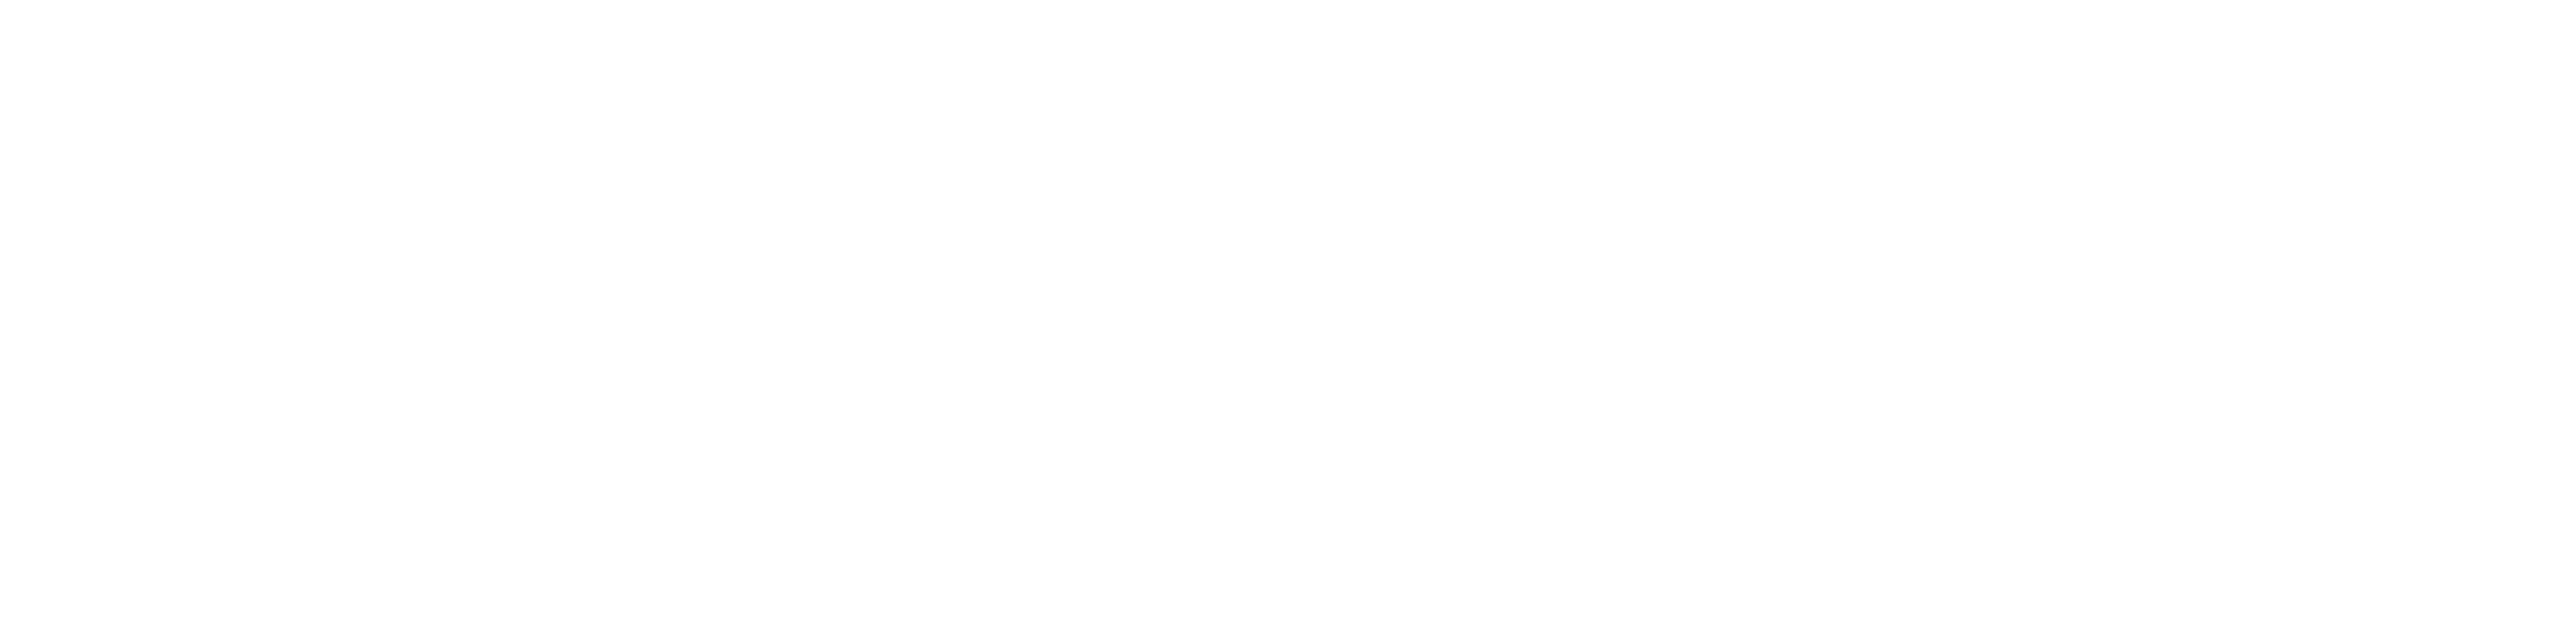

2020-06-04 00:55:27,999 logger INFO loss 3.09, 3D Dis:  6.47mm, shiftDiff: 43278.046875, MemUsed:50.86
2020-06-04 00:55:34,282 logger INFO loss 3.09, 3D Dis:  6.41mm, shiftDiff: 42882.234375, MemUsed:50.86
2020-06-04 00:55:40,623 logger INFO loss 3.08, 3D Dis:  6.35mm, shiftDiff: 42471.058594, MemUsed:50.86
2020-06-04 00:55:47,043 logger INFO loss 3.07, 3D Dis:  6.29mm, shiftDiff: 42055.300781, MemUsed:50.86
2020-06-04 00:55:53,509 logger INFO loss 3.05, 3D Dis:  6.23mm, shiftDiff: 41647.117188, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


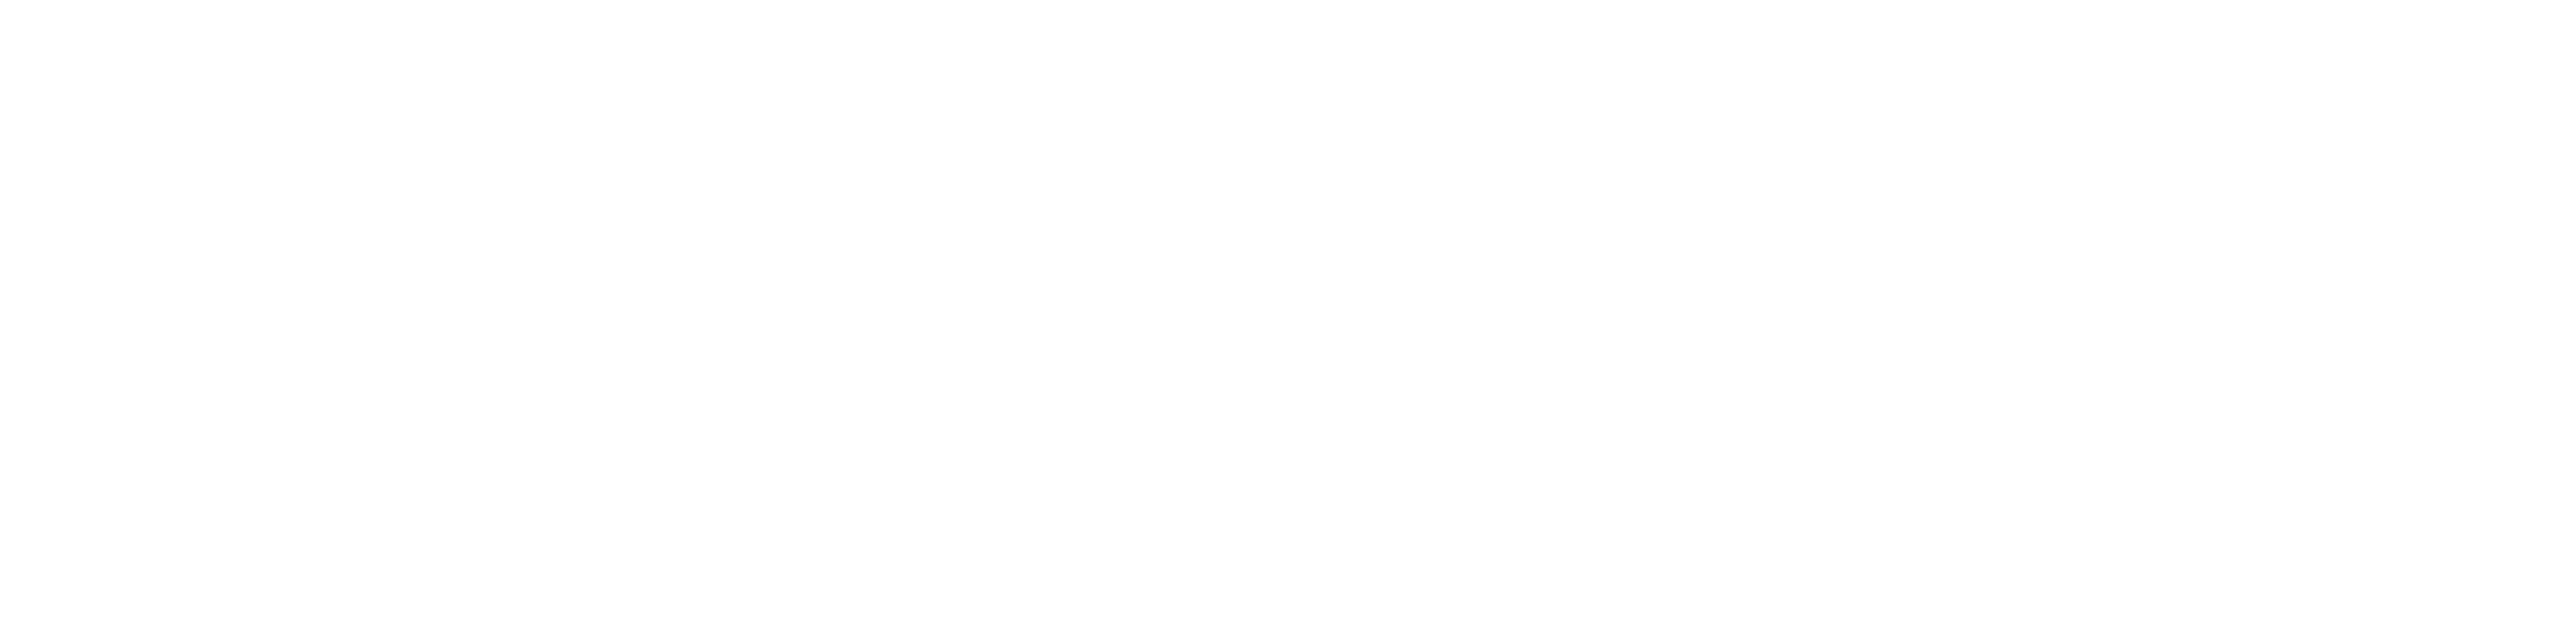

2020-06-04 00:56:18,127 logger INFO loss 3.04, 3D Dis:  6.17mm, shiftDiff: 41254.679688, MemUsed:50.86
2020-06-04 00:56:24,397 logger INFO loss 3.03, 3D Dis:  6.11mm, shiftDiff: 40874.722656, MemUsed:50.86
2020-06-04 00:56:30,781 logger INFO loss 3.02, 3D Dis:  6.06mm, shiftDiff: 40533.468750, MemUsed:50.86
2020-06-04 00:56:37,300 logger INFO loss 3.01, 3D Dis:  6.00mm, shiftDiff: 40244.078125, MemUsed:50.86
2020-06-04 00:56:43,649 logger INFO loss 3.01, 3D Dis:  5.96mm, shiftDiff: 39997.714844, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


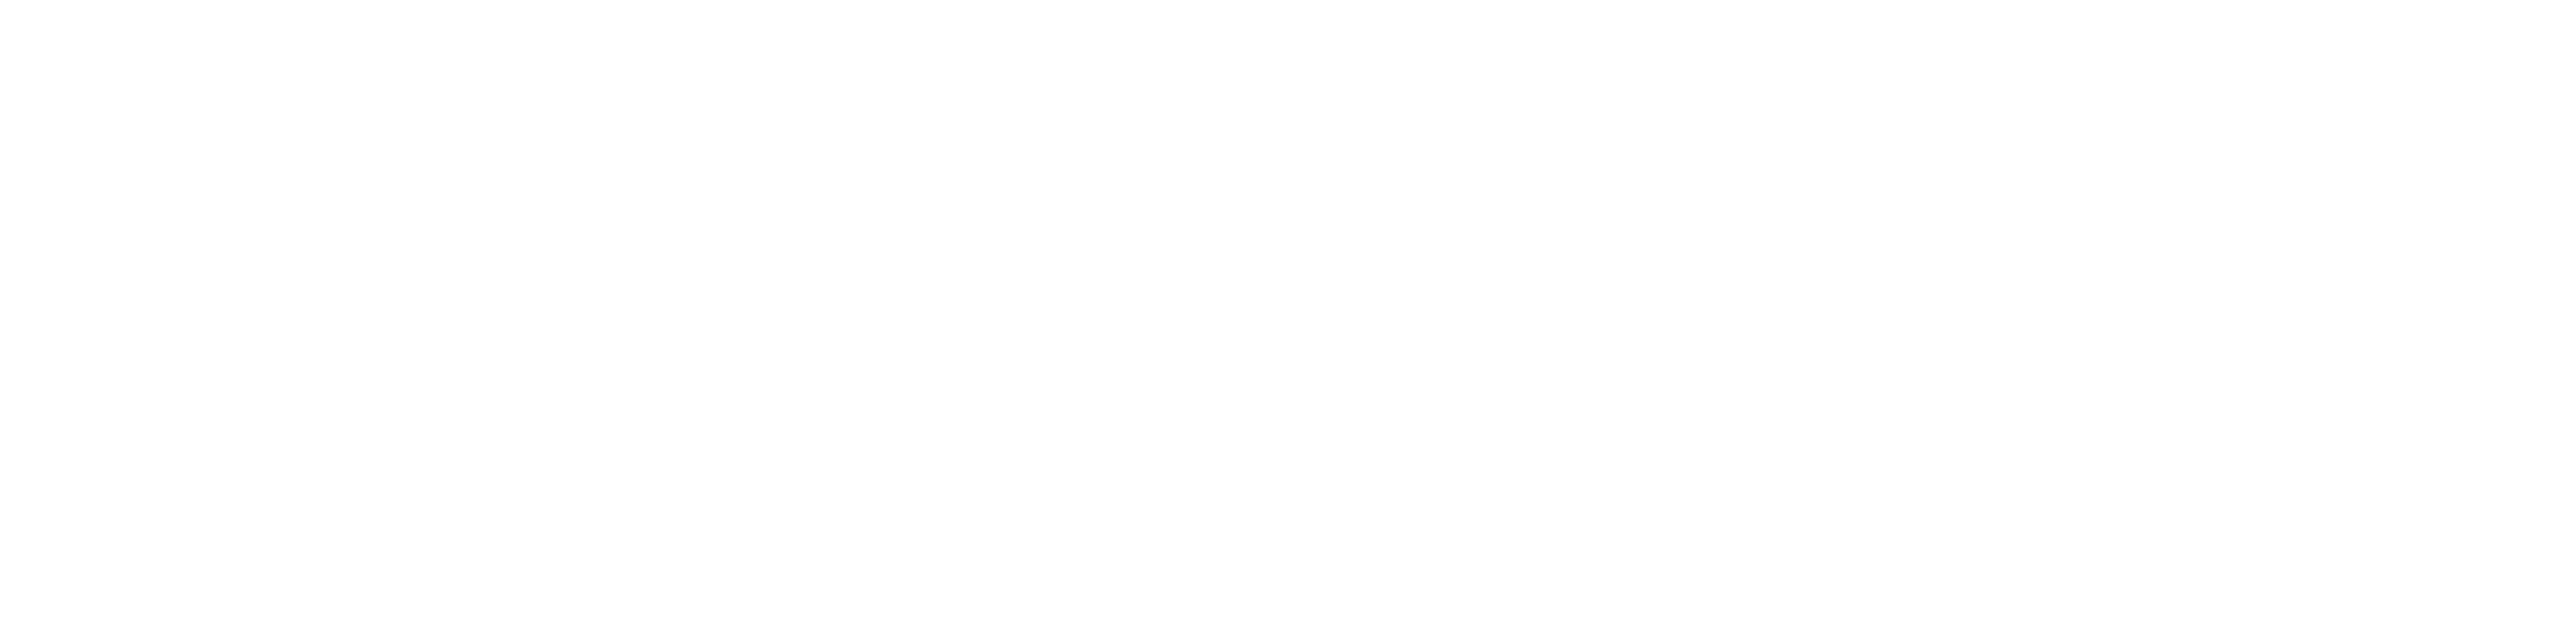

2020-06-04 00:57:08,254 logger INFO loss 3.00, 3D Dis:  5.93mm, shiftDiff: 39793.695312, MemUsed:50.86
2020-06-04 00:57:14,598 logger INFO loss 3.00, 3D Dis:  5.90mm, shiftDiff: 39635.859375, MemUsed:50.86
2020-06-04 00:57:20,926 logger INFO loss 2.99, 3D Dis:  5.87mm, shiftDiff: 39515.898438, MemUsed:50.86
2020-06-04 00:57:27,451 logger INFO loss 2.98, 3D Dis:  5.85mm, shiftDiff: 39422.921875, MemUsed:50.86
2020-06-04 00:57:33,907 logger INFO loss 2.98, 3D Dis:  5.84mm, shiftDiff: 39329.304688, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


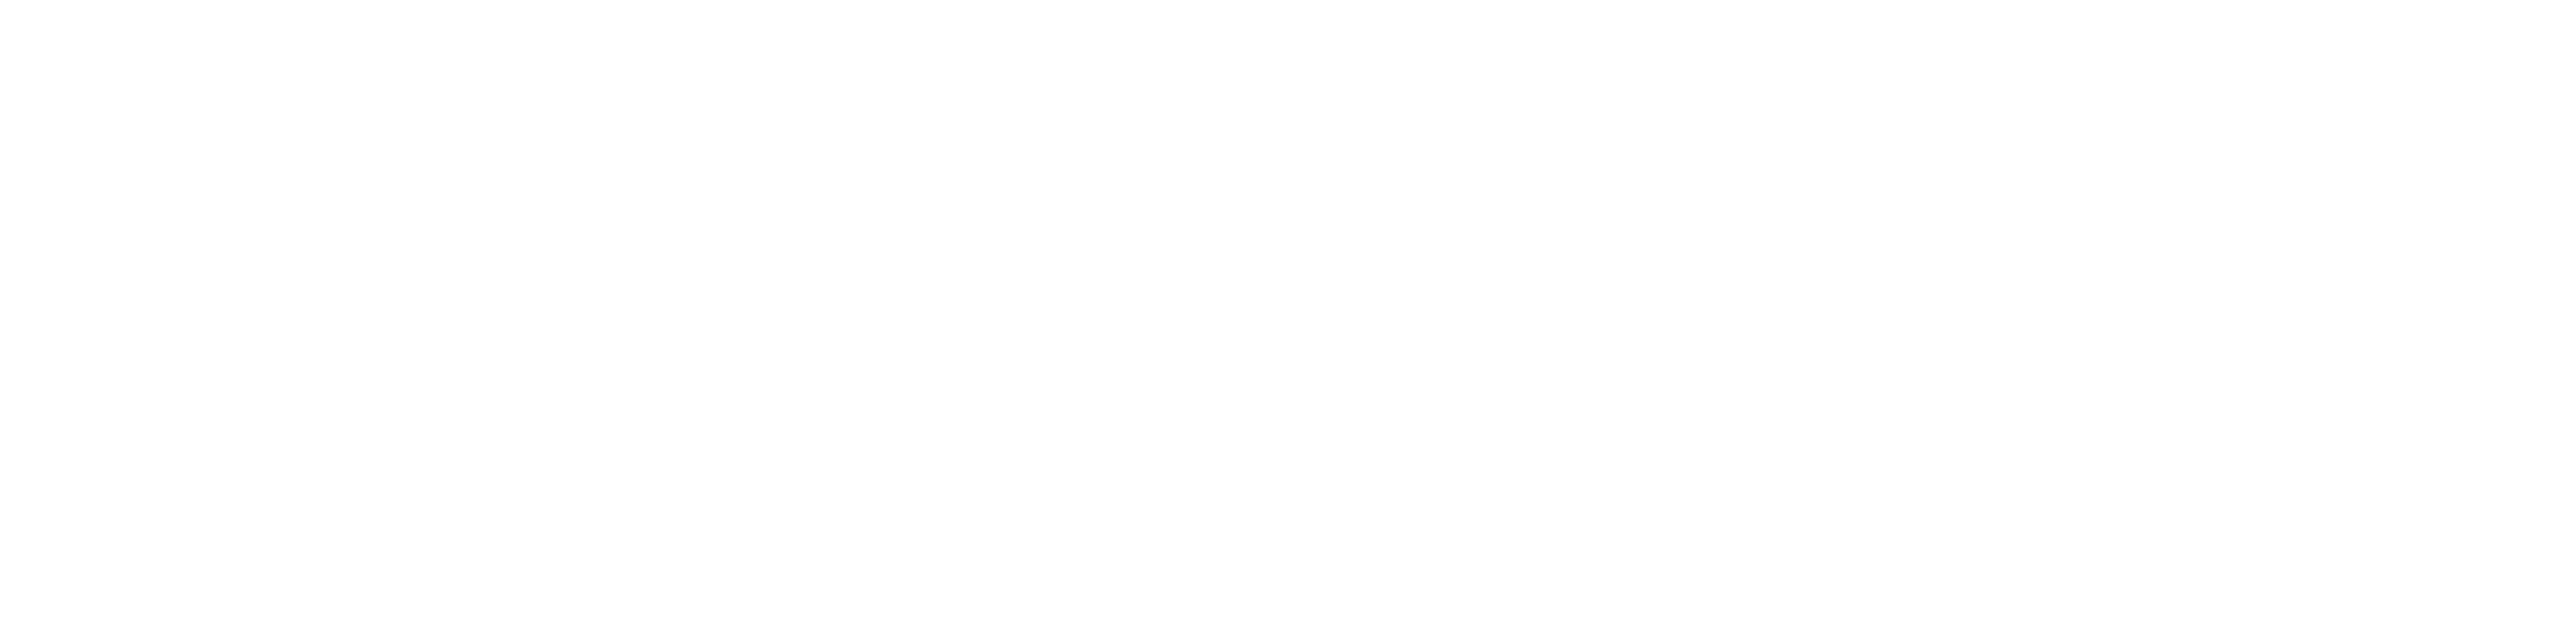

2020-06-04 00:57:58,508 logger INFO loss 2.98, 3D Dis:  5.83mm, shiftDiff: 39222.757812, MemUsed:50.86
2020-06-04 00:58:04,754 logger INFO loss 2.97, 3D Dis:  5.81mm, shiftDiff: 39101.429688, MemUsed:50.86
2020-06-04 00:58:11,209 logger INFO loss 2.97, 3D Dis:  5.79mm, shiftDiff: 38965.222656, MemUsed:50.86
2020-06-04 00:58:17,643 logger INFO loss 2.97, 3D Dis:  5.77mm, shiftDiff: 38819.289062, MemUsed:50.86
2020-06-04 00:58:24,175 logger INFO loss 2.96, 3D Dis:  5.75mm, shiftDiff: 38672.011719, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


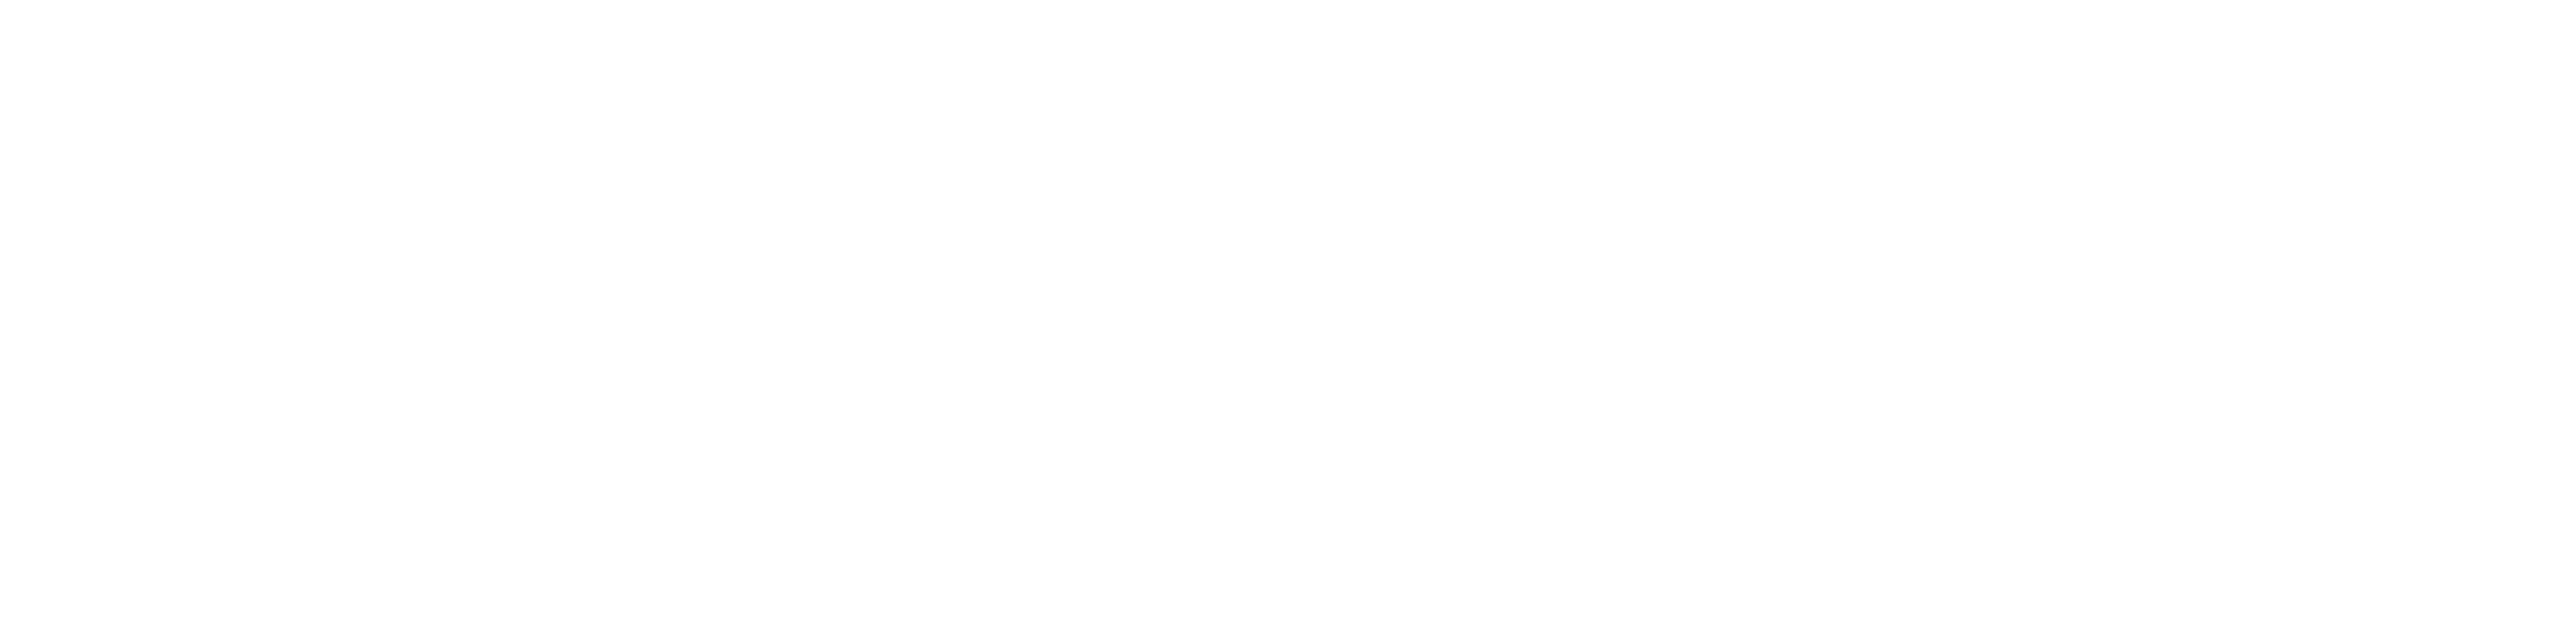

2020-06-04 00:58:48,676 logger INFO loss 2.96, 3D Dis:  5.73mm, shiftDiff: 38538.796875, MemUsed:50.86
2020-06-04 00:58:55,053 logger INFO loss 2.96, 3D Dis:  5.71mm, shiftDiff: 38426.316406, MemUsed:50.86
2020-06-04 00:59:01,431 logger INFO loss 2.96, 3D Dis:  5.69mm, shiftDiff: 38333.839844, MemUsed:50.86
2020-06-04 00:59:07,875 logger INFO loss 2.95, 3D Dis:  5.68mm, shiftDiff: 38254.511719, MemUsed:50.86
2020-06-04 00:59:14,398 logger INFO loss 2.95, 3D Dis:  5.67mm, shiftDiff: 38177.367188, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


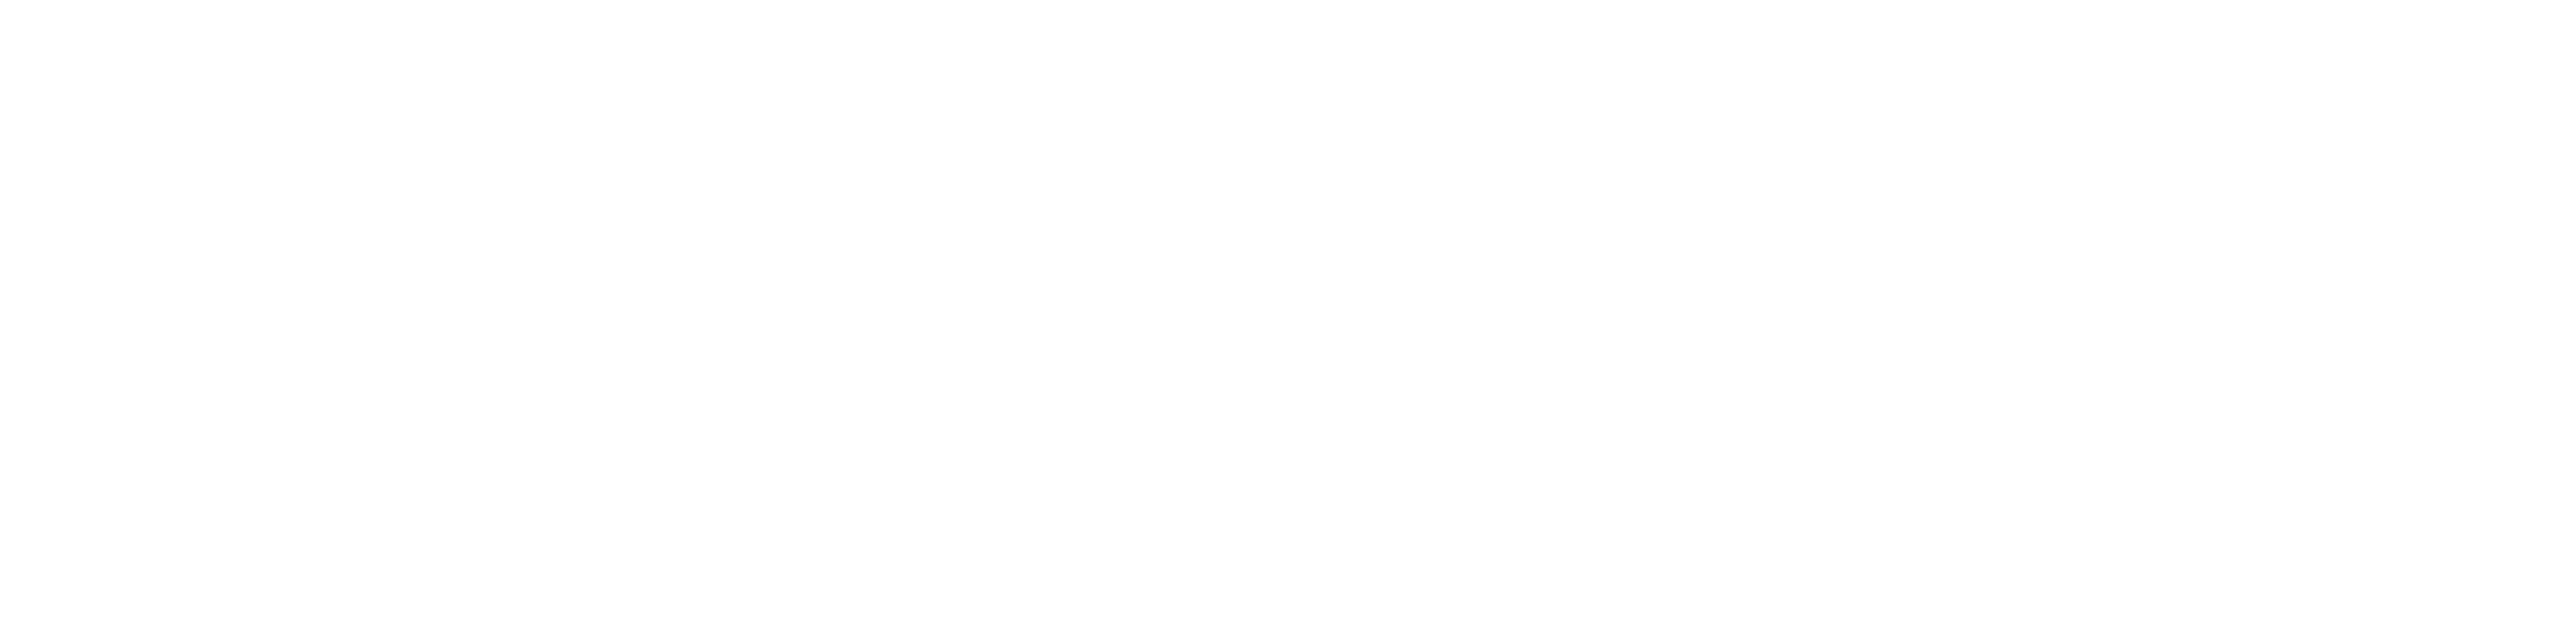

2020-06-04 00:59:38,998 logger INFO loss 2.95, 3D Dis:  5.66mm, shiftDiff: 38095.968750, MemUsed:50.86
2020-06-04 00:59:45,300 logger INFO loss 2.95, 3D Dis:  5.64mm, shiftDiff: 38013.710938, MemUsed:50.86
2020-06-04 00:59:51,696 logger INFO loss 2.95, 3D Dis:  5.63mm, shiftDiff: 37931.800781, MemUsed:50.86
2020-06-04 00:59:58,022 logger INFO loss 2.95, 3D Dis:  5.62mm, shiftDiff: 37850.566406, MemUsed:50.86
2020-06-04 01:00:04,398 logger INFO loss 2.94, 3D Dis:  5.61mm, shiftDiff: 37769.945312, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


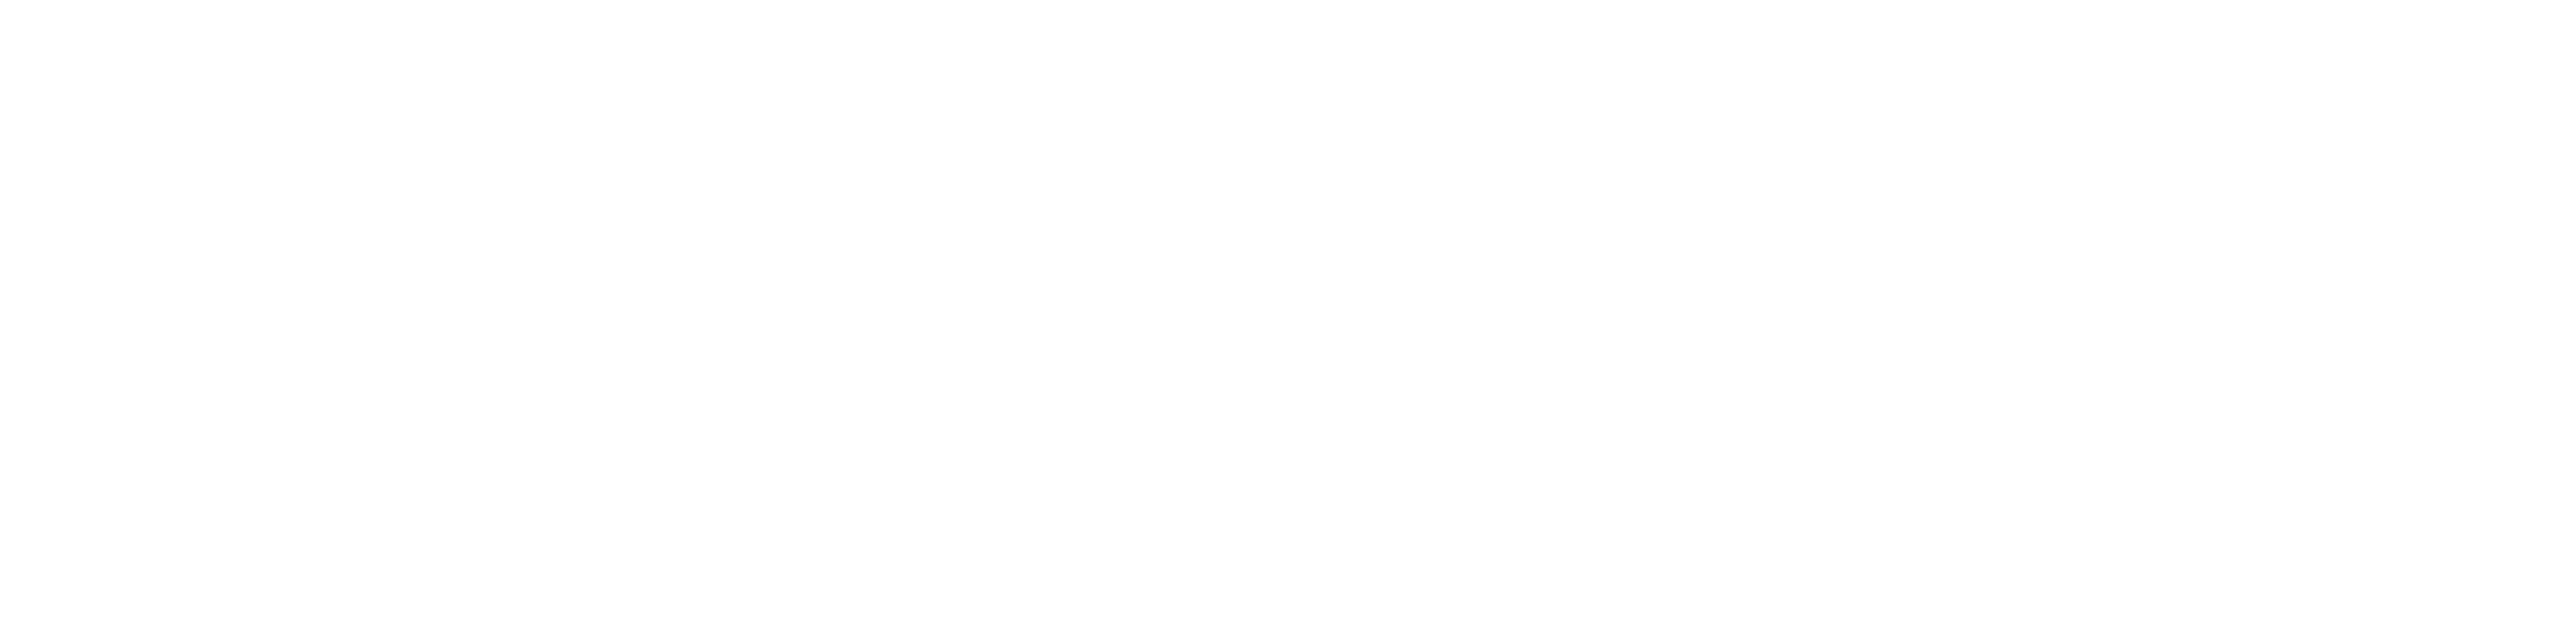

2020-06-04 01:00:28,950 logger INFO loss 2.94, 3D Dis:  5.60mm, shiftDiff: 37690.363281, MemUsed:50.86
2020-06-04 01:00:35,371 logger INFO loss 2.94, 3D Dis:  5.58mm, shiftDiff: 37618.570312, MemUsed:50.86
2020-06-04 01:00:41,811 logger INFO loss 2.94, 3D Dis:  5.57mm, shiftDiff: 37554.125000, MemUsed:50.86
2020-06-04 01:00:48,202 logger INFO loss 2.94, 3D Dis:  5.56mm, shiftDiff: 37492.414062, MemUsed:50.86
2020-06-04 01:00:54,724 logger INFO loss 2.94, 3D Dis:  5.55mm, shiftDiff: 37429.710938, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


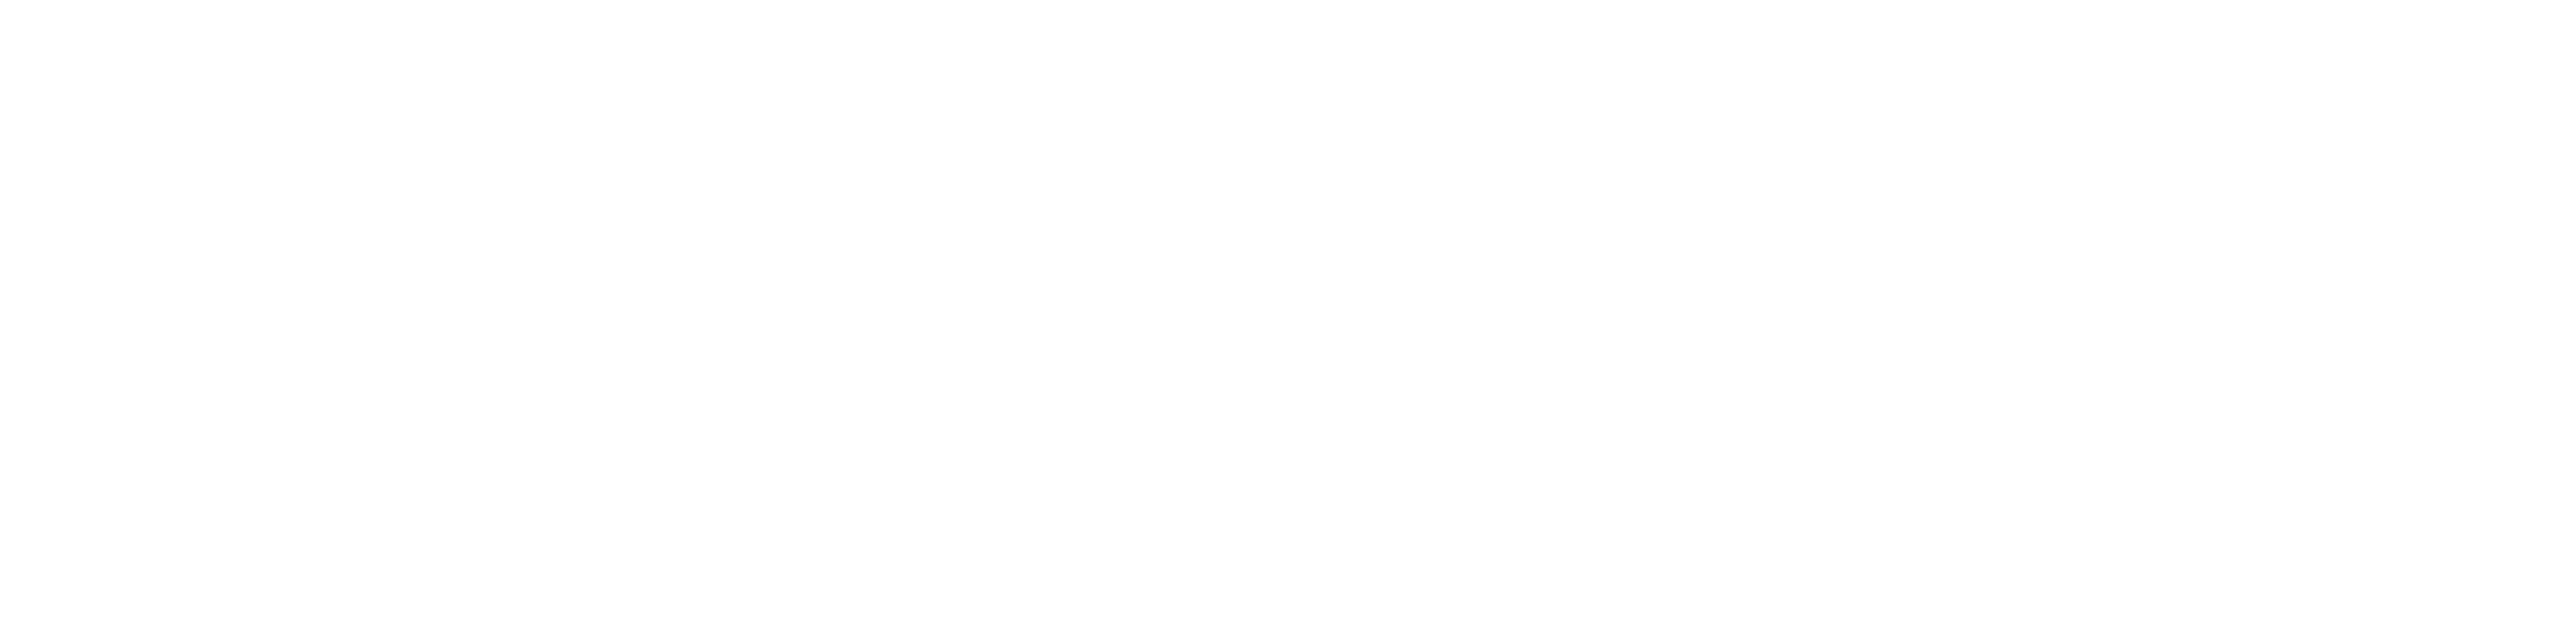

2020-06-04 01:01:19,288 logger INFO loss 2.94, 3D Dis:  5.55mm, shiftDiff: 37367.503906, MemUsed:50.86
2020-06-04 01:01:25,652 logger INFO loss 2.94, 3D Dis:  5.54mm, shiftDiff: 37310.746094, MemUsed:50.86
2020-06-04 01:01:32,046 logger INFO loss 2.94, 3D Dis:  5.53mm, shiftDiff: 37258.675781, MemUsed:50.86
2020-06-04 01:01:38,430 logger INFO loss 2.94, 3D Dis:  5.52mm, shiftDiff: 37208.609375, MemUsed:50.86
2020-06-04 01:01:44,960 logger INFO loss 2.94, 3D Dis:  5.51mm, shiftDiff: 37161.492188, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


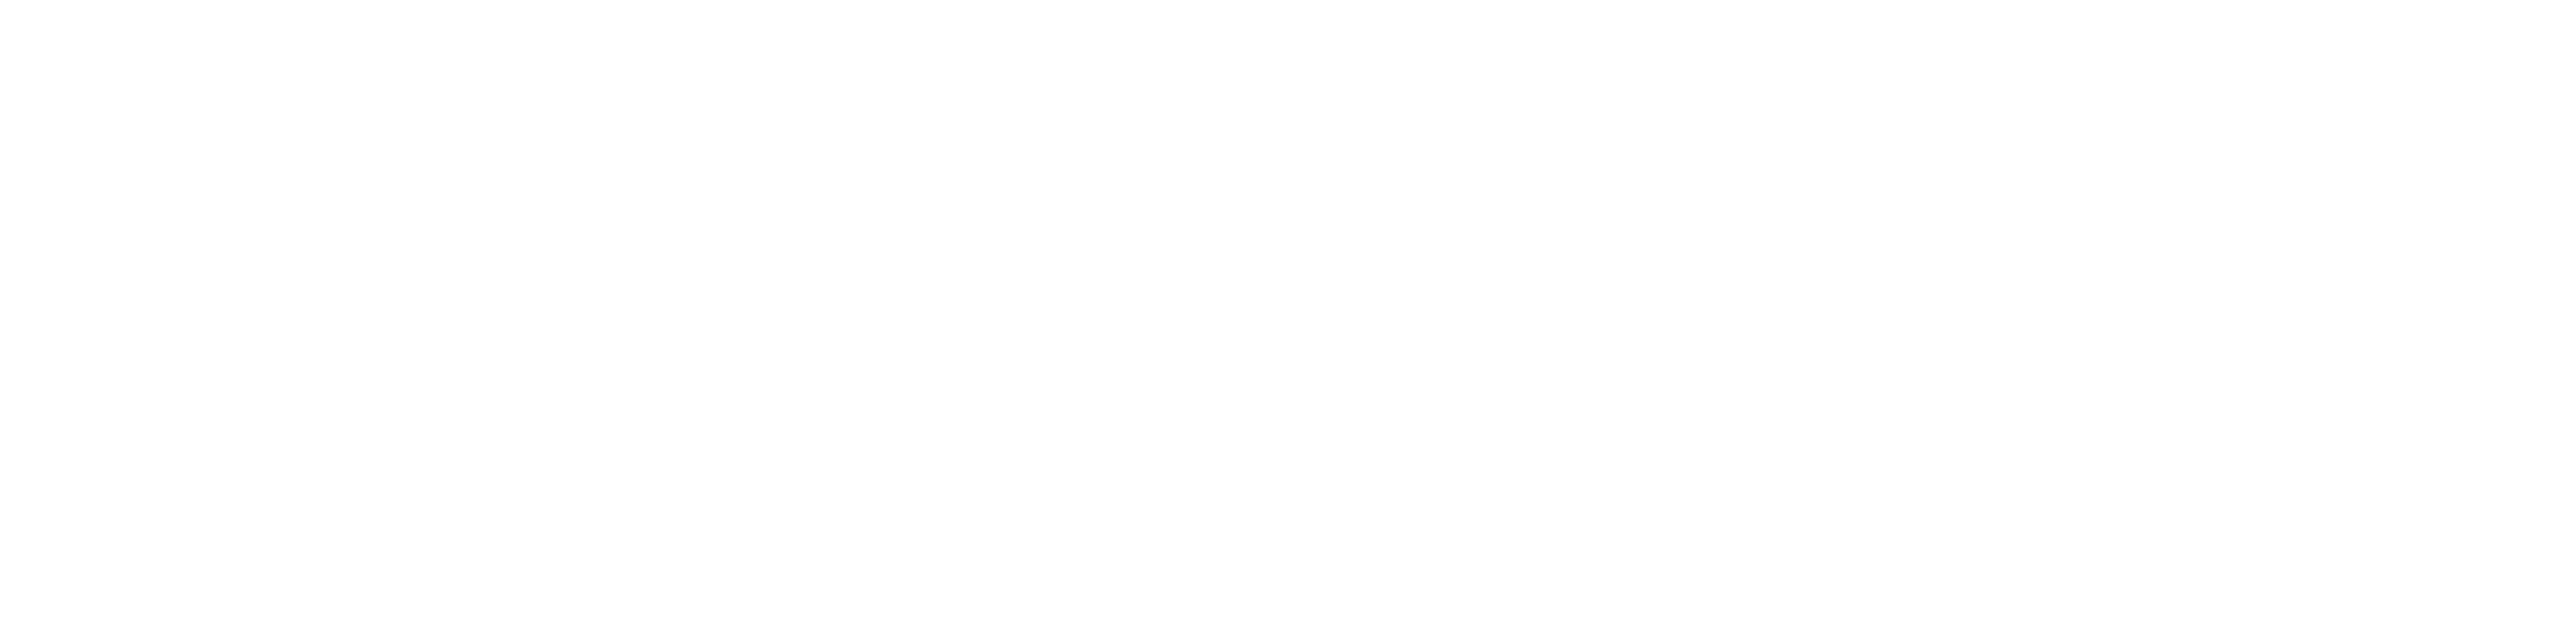

2020-06-04 01:02:09,625 logger INFO loss 2.94, 3D Dis:  5.51mm, shiftDiff: 37117.554688, MemUsed:50.86
2020-06-04 01:02:15,977 logger INFO loss 2.94, 3D Dis:  5.50mm, shiftDiff: 37080.218750, MemUsed:50.86
2020-06-04 01:02:22,361 logger INFO loss 2.94, 3D Dis:  5.49mm, shiftDiff: 37048.218750, MemUsed:50.86
2020-06-04 01:02:28,701 logger INFO loss 2.93, 3D Dis:  5.49mm, shiftDiff: 37015.578125, MemUsed:50.86
2020-06-04 01:02:35,307 logger INFO loss 2.93, 3D Dis:  5.48mm, shiftDiff: 36981.226562, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


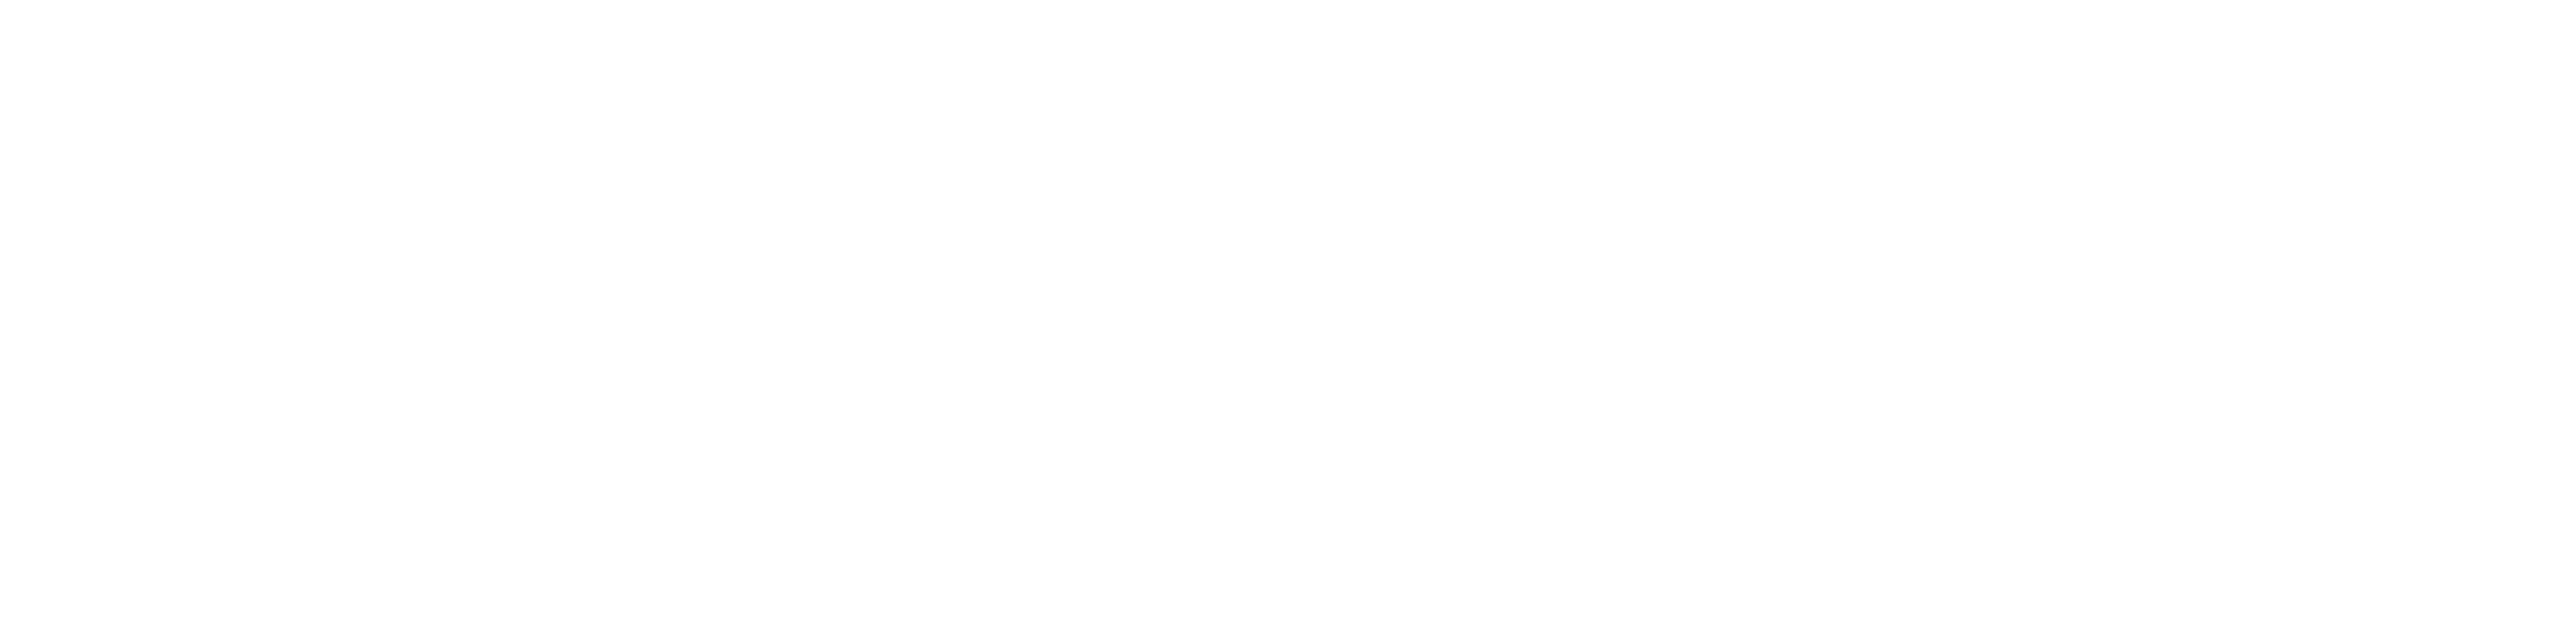

2020-06-04 01:02:59,874 logger INFO loss 2.93, 3D Dis:  5.48mm, shiftDiff: 36945.273438, MemUsed:50.86
2020-06-04 01:03:06,229 logger INFO loss 2.93, 3D Dis:  5.47mm, shiftDiff: 36908.593750, MemUsed:50.86
2020-06-04 01:03:12,572 logger INFO loss 2.93, 3D Dis:  5.47mm, shiftDiff: 36872.531250, MemUsed:50.86
2020-06-04 01:03:19,024 logger INFO loss 2.93, 3D Dis:  5.46mm, shiftDiff: 36839.851562, MemUsed:50.86
2020-06-04 01:03:25,466 logger INFO loss 2.93, 3D Dis:  5.46mm, shiftDiff: 36811.898438, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


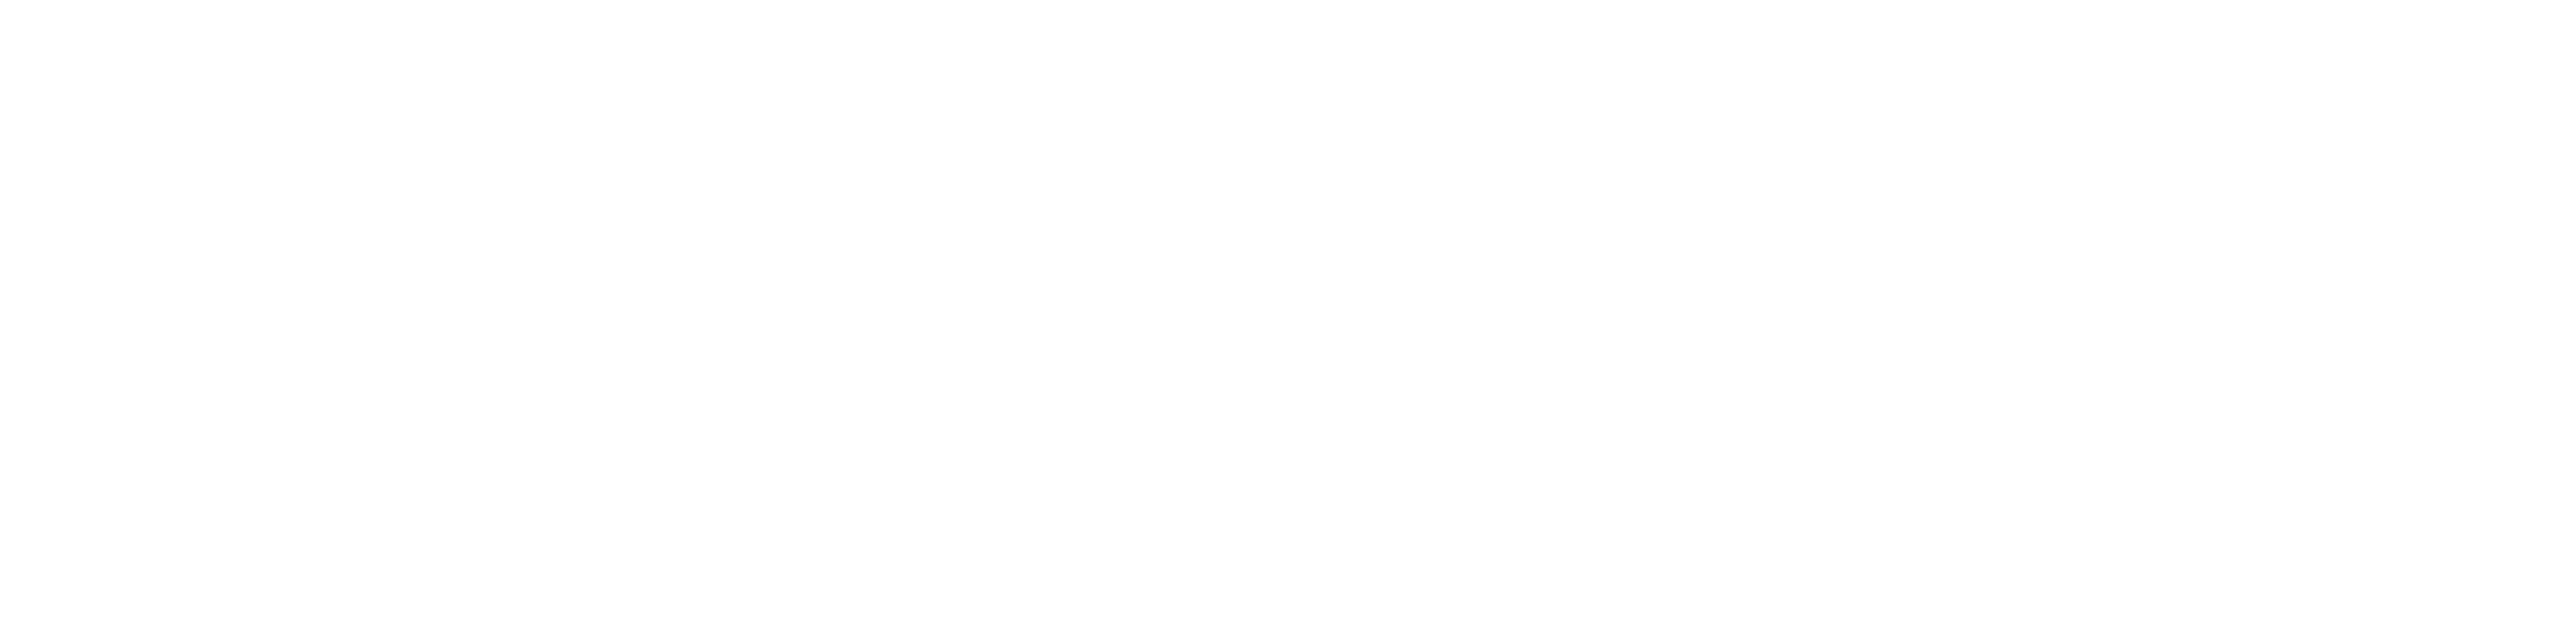

2020-06-04 01:03:50,084 logger INFO loss 2.93, 3D Dis:  5.45mm, shiftDiff: 36787.652344, MemUsed:50.86
2020-06-04 01:03:56,402 logger INFO loss 2.93, 3D Dis:  5.45mm, shiftDiff: 36768.351562, MemUsed:50.86
2020-06-04 01:04:02,872 logger INFO loss 2.93, 3D Dis:  5.45mm, shiftDiff: 36750.023438, MemUsed:50.86
2020-06-04 01:04:09,371 logger INFO loss 2.93, 3D Dis:  5.44mm, shiftDiff: 36731.003906, MemUsed:50.86
2020-06-04 01:04:15,912 logger INFO loss 2.93, 3D Dis:  5.44mm, shiftDiff: 36709.507812, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


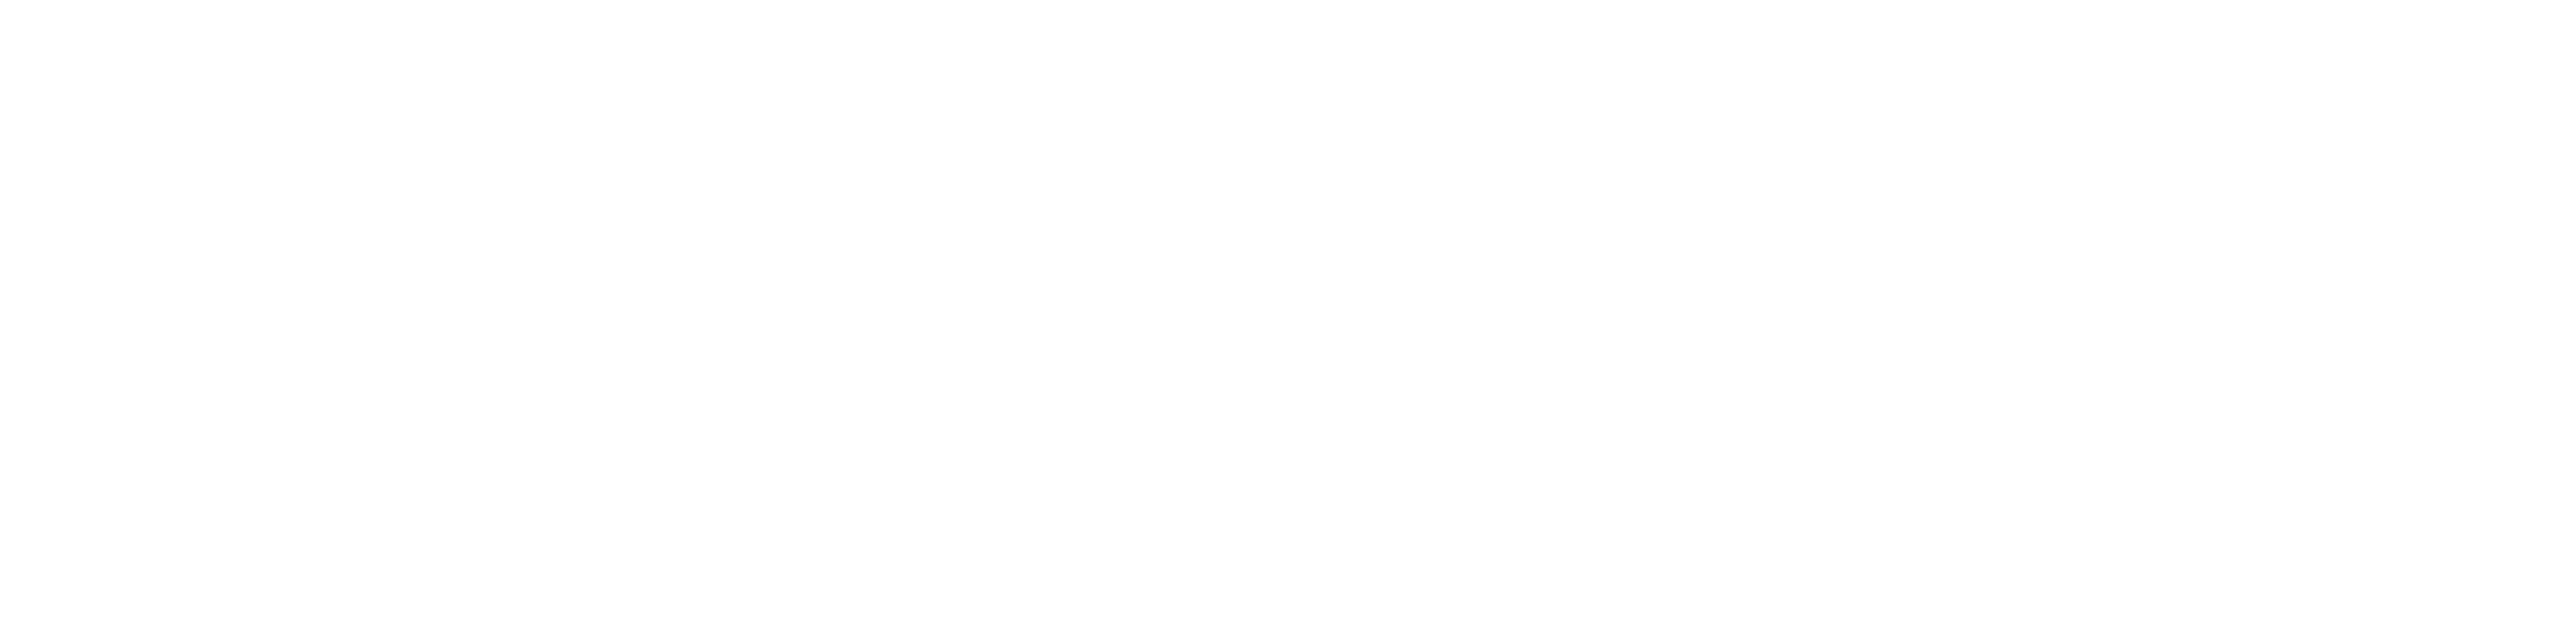

2020-06-04 01:04:40,413 logger INFO loss 2.93, 3D Dis:  5.44mm, shiftDiff: 36689.433594, MemUsed:50.86
2020-06-04 01:04:46,843 logger INFO loss 2.93, 3D Dis:  5.44mm, shiftDiff: 36669.992188, MemUsed:50.86
2020-06-04 01:04:53,185 logger INFO loss 2.93, 3D Dis:  5.43mm, shiftDiff: 36651.726562, MemUsed:50.86
2020-06-04 01:04:59,716 logger INFO loss 2.93, 3D Dis:  5.43mm, shiftDiff: 36636.343750, MemUsed:50.86
2020-06-04 01:05:06,163 logger INFO loss 2.93, 3D Dis:  5.43mm, shiftDiff: 36622.609375, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


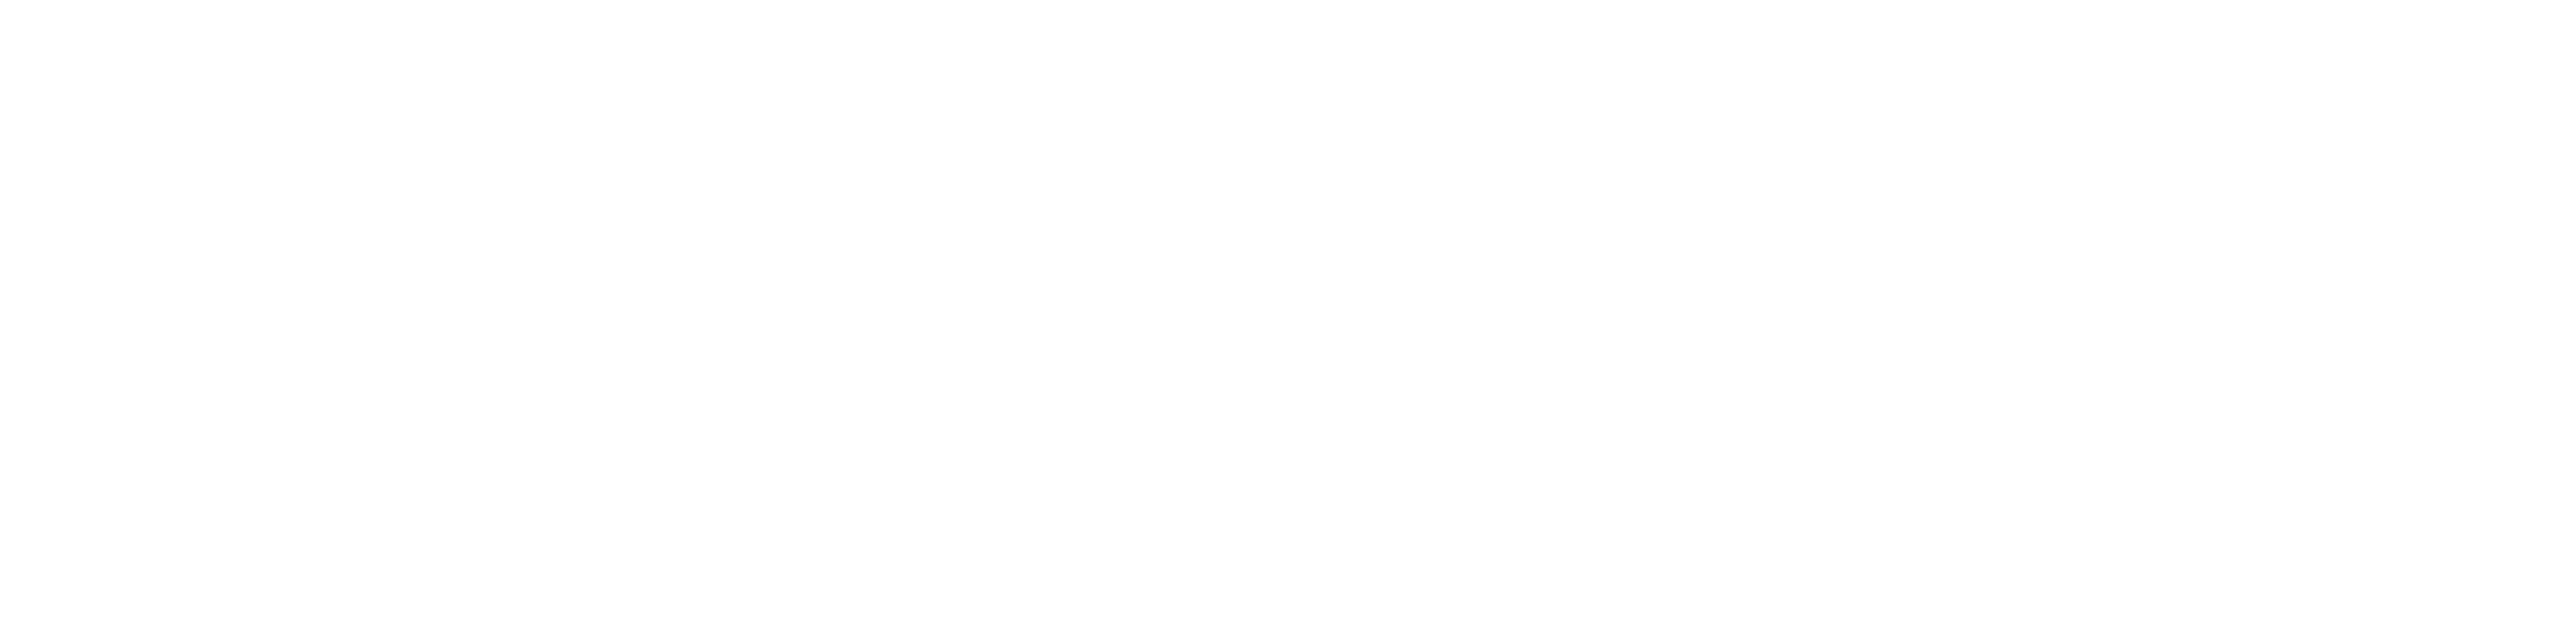

2020-06-04 01:05:30,704 logger INFO loss 2.93, 3D Dis:  5.43mm, shiftDiff: 36606.929688, MemUsed:50.86
2020-06-04 01:05:37,017 logger INFO loss 2.93, 3D Dis:  5.42mm, shiftDiff: 36586.625000, MemUsed:50.86
2020-06-04 01:05:43,399 logger INFO loss 2.93, 3D Dis:  5.42mm, shiftDiff: 36563.937500, MemUsed:50.86
2020-06-04 01:05:49,793 logger INFO loss 2.93, 3D Dis:  5.42mm, shiftDiff: 36542.054688, MemUsed:50.86
2020-06-04 01:05:56,234 logger INFO loss 2.93, 3D Dis:  5.41mm, shiftDiff: 36524.328125, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


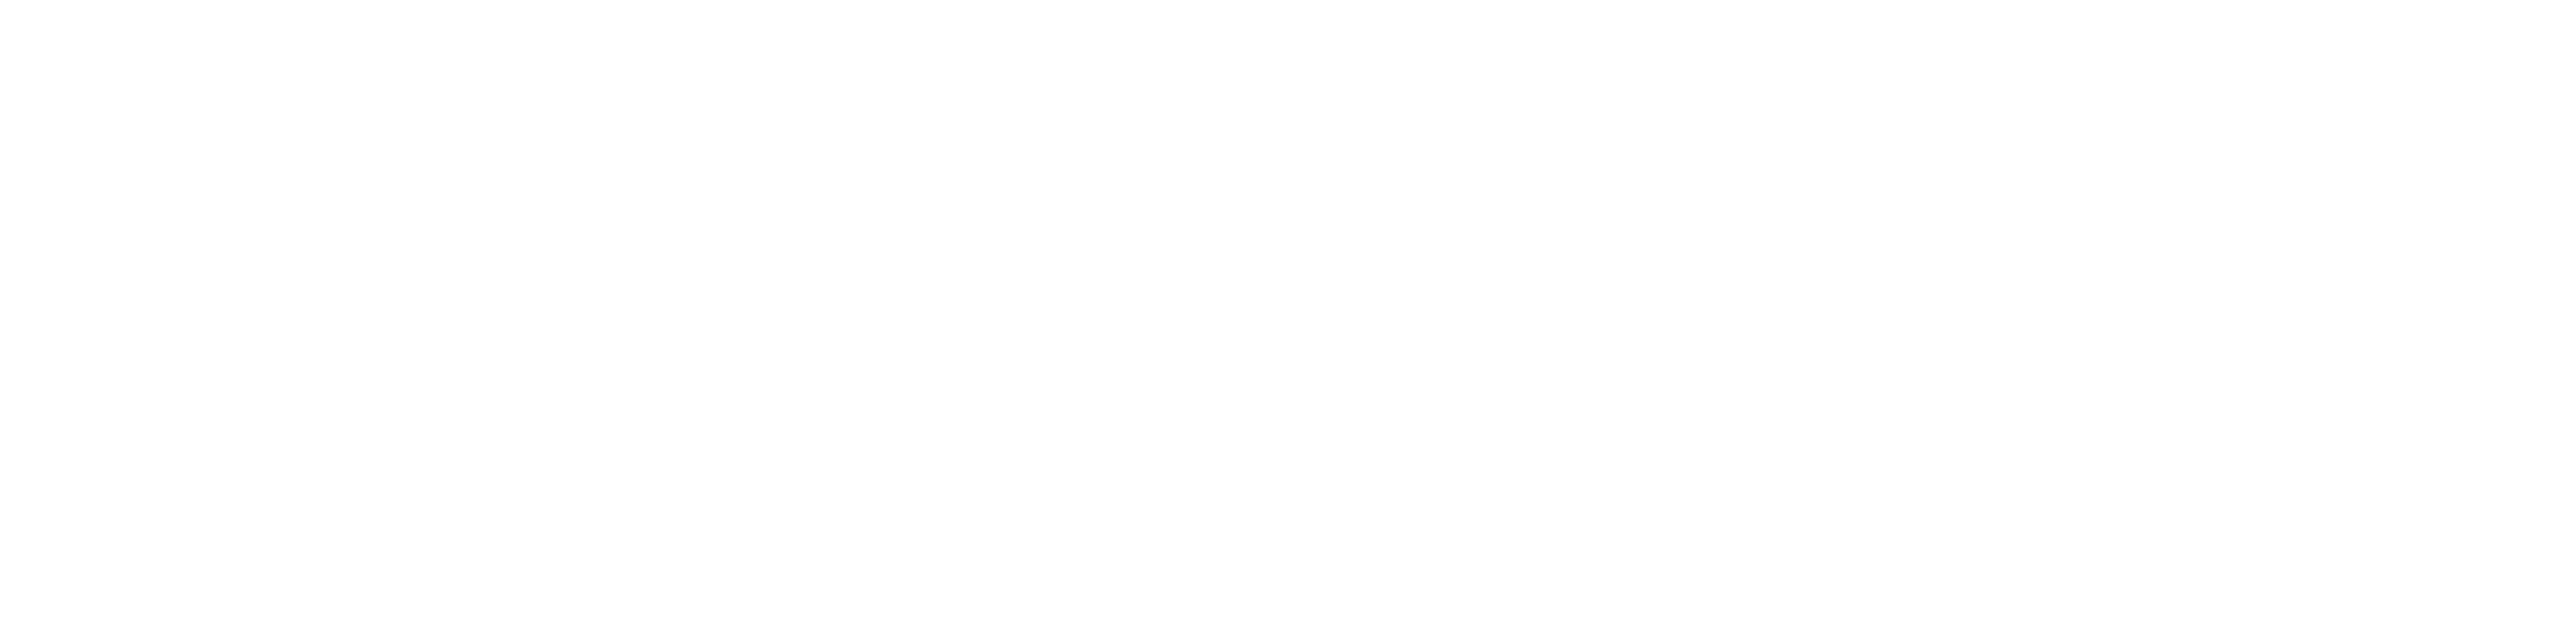

2020-06-04 01:06:20,752 logger INFO loss 2.93, 3D Dis:  5.41mm, shiftDiff: 36508.460938, MemUsed:50.86
2020-06-04 01:06:27,203 logger INFO loss 2.93, 3D Dis:  5.41mm, shiftDiff: 36492.960938, MemUsed:50.86
2020-06-04 01:06:33,576 logger INFO loss 2.93, 3D Dis:  5.41mm, shiftDiff: 36479.179688, MemUsed:50.86
2020-06-04 01:06:40,061 logger INFO loss 2.93, 3D Dis:  5.40mm, shiftDiff: 36464.718750, MemUsed:50.86
2020-06-04 01:06:46,601 logger INFO loss 2.93, 3D Dis:  5.40mm, shiftDiff: 36450.058594, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


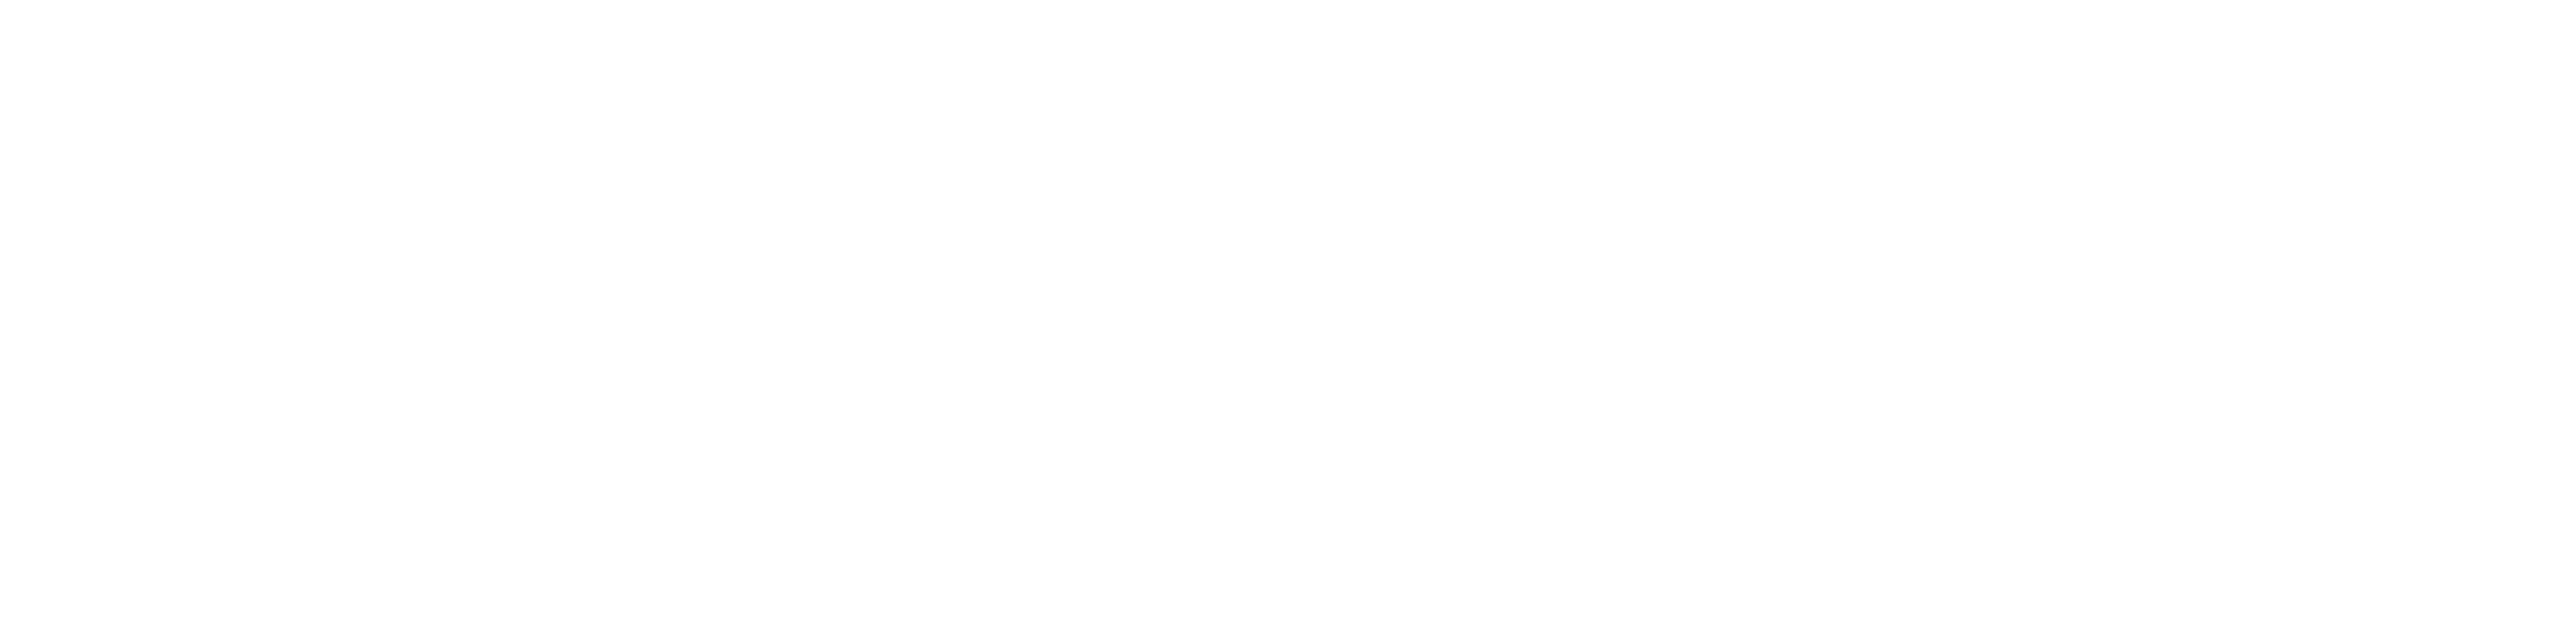

2020-06-04 01:07:11,239 logger INFO loss 2.93, 3D Dis:  5.40mm, shiftDiff: 36435.601562, MemUsed:50.86
2020-06-04 01:07:17,524 logger INFO loss 2.93, 3D Dis:  5.40mm, shiftDiff: 36423.074219, MemUsed:50.86
2020-06-04 01:07:23,938 logger INFO loss 2.93, 3D Dis:  5.40mm, shiftDiff: 36412.359375, MemUsed:50.86
2020-06-04 01:07:30,427 logger INFO loss 2.93, 3D Dis:  5.39mm, shiftDiff: 36401.820312, MemUsed:50.86
2020-06-04 01:07:37,013 logger INFO loss 2.93, 3D Dis:  5.39mm, shiftDiff: 36390.179688, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


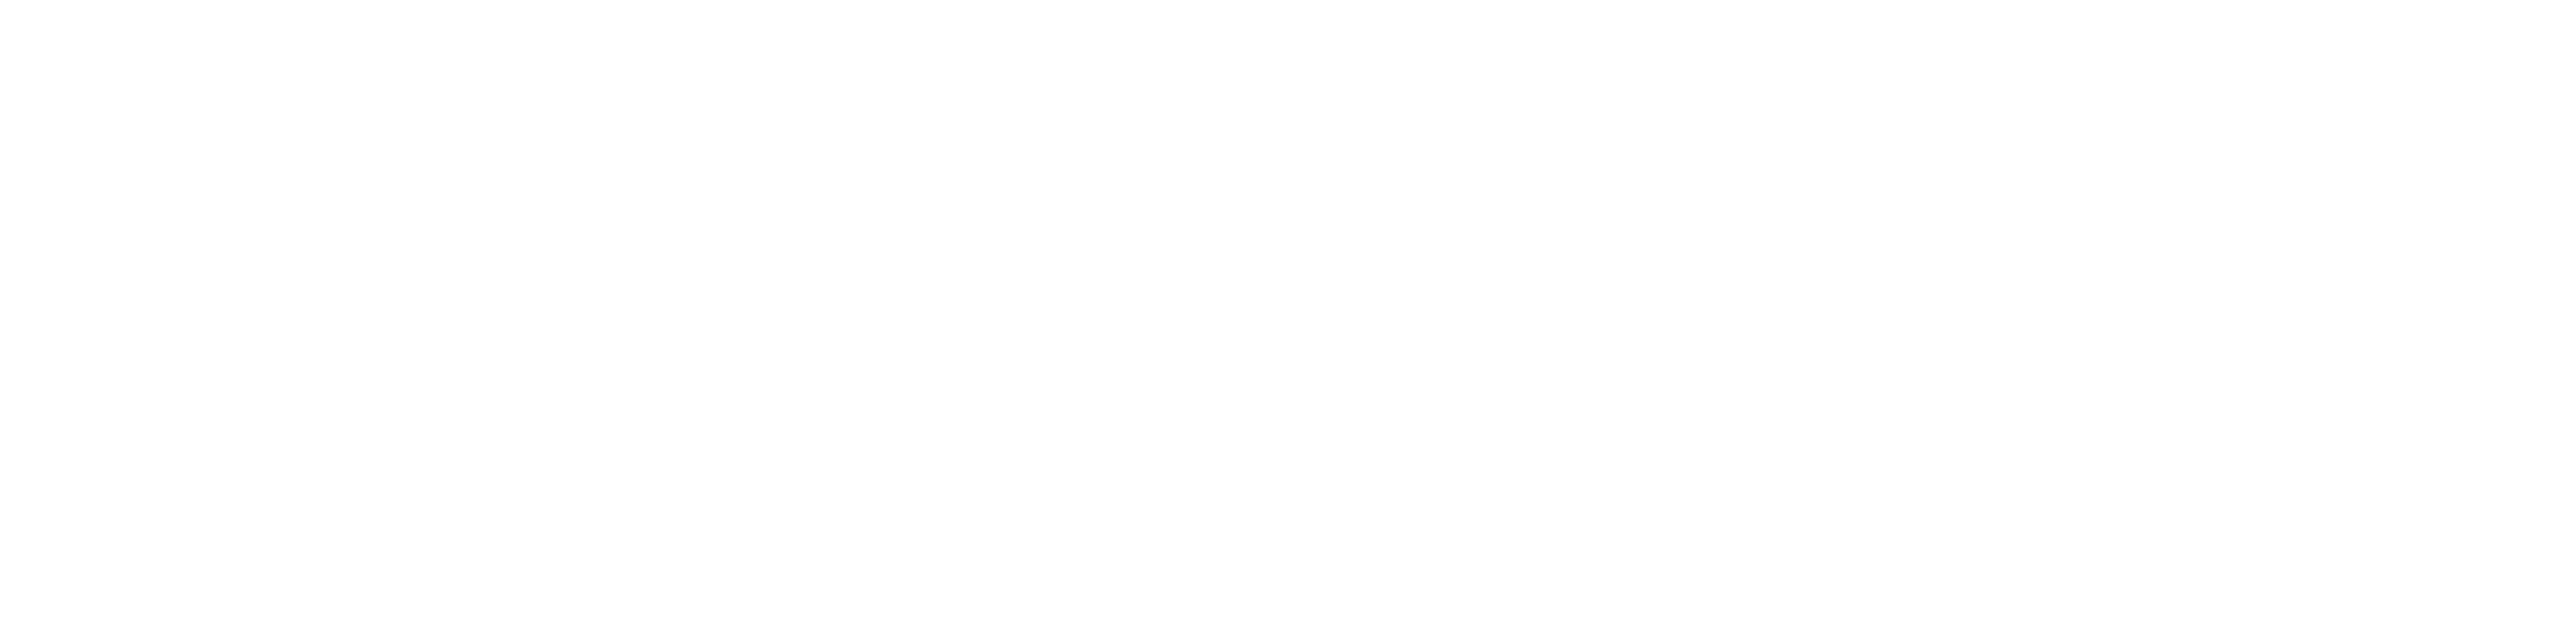

2020-06-04 01:08:01,564 logger INFO loss 2.93, 3D Dis:  5.39mm, shiftDiff: 36377.531250, MemUsed:50.86
2020-06-04 01:08:07,872 logger INFO loss 2.93, 3D Dis:  5.39mm, shiftDiff: 36366.140625, MemUsed:50.86
2020-06-04 01:08:14,279 logger INFO loss 2.93, 3D Dis:  5.39mm, shiftDiff: 36356.355469, MemUsed:50.86
2020-06-04 01:08:20,819 logger INFO loss 2.93, 3D Dis:  5.39mm, shiftDiff: 36348.015625, MemUsed:50.86
2020-06-04 01:08:27,369 logger INFO loss 2.93, 3D Dis:  5.38mm, shiftDiff: 36341.414062, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


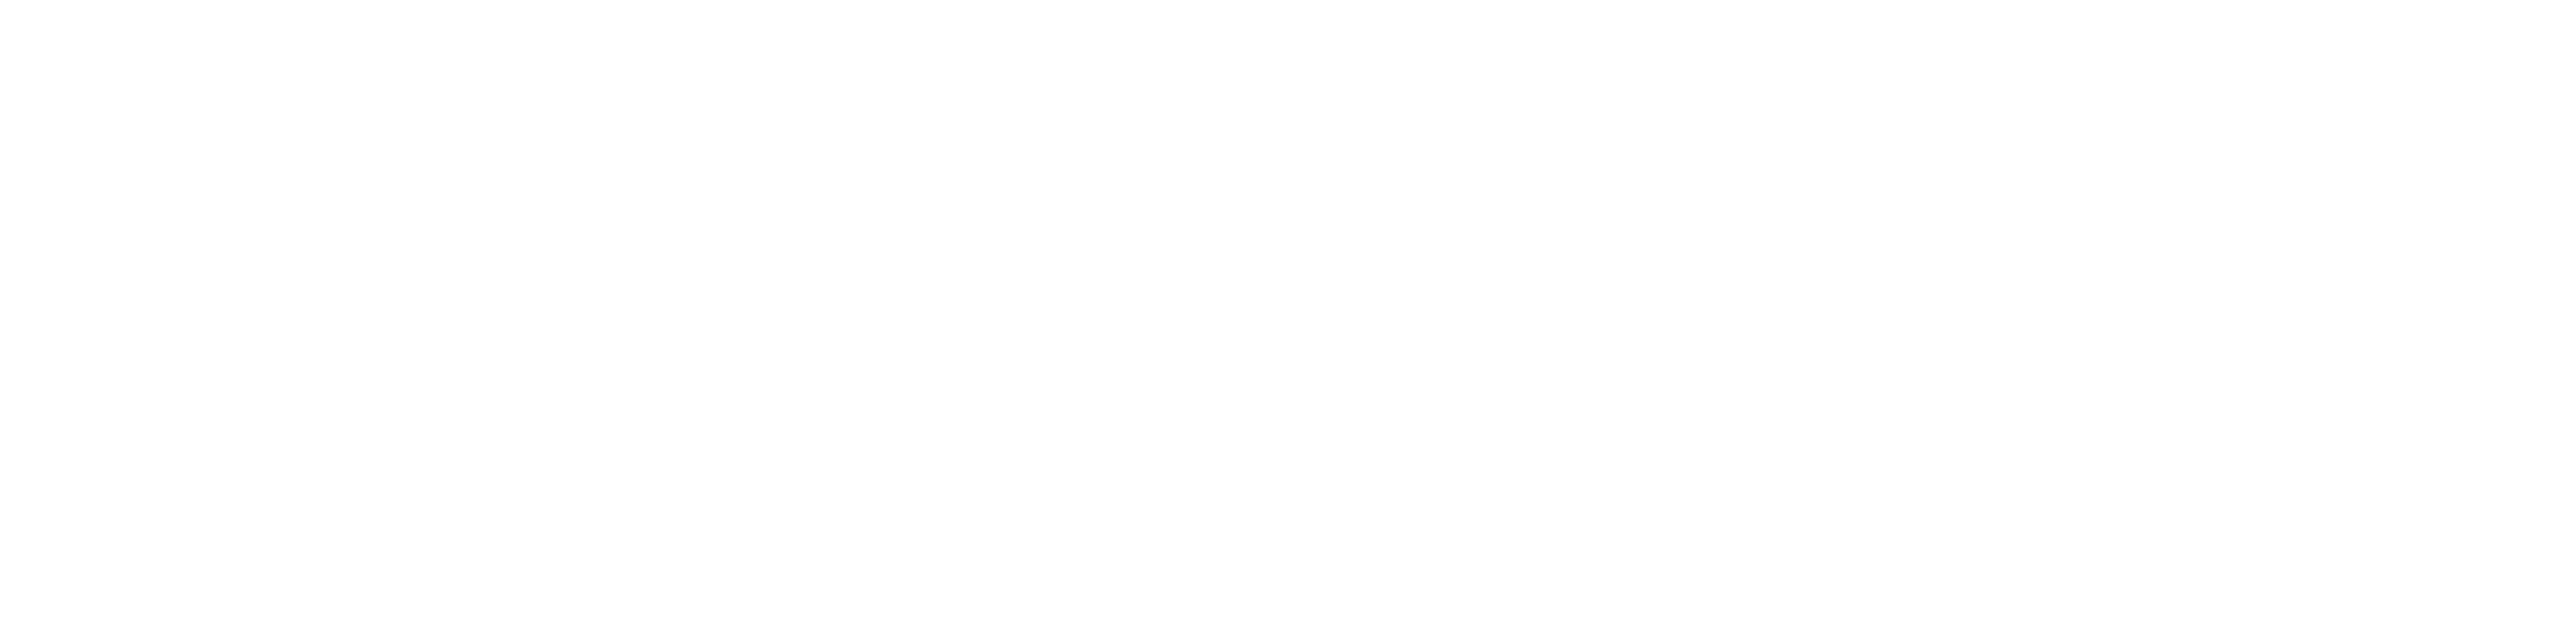

2020-06-04 01:08:51,939 logger INFO loss 2.93, 3D Dis:  5.38mm, shiftDiff: 36332.453125, MemUsed:50.86
2020-06-04 01:08:58,308 logger INFO loss 2.93, 3D Dis:  5.38mm, shiftDiff: 36323.785156, MemUsed:50.86
2020-06-04 01:09:04,670 logger INFO loss 2.93, 3D Dis:  5.38mm, shiftDiff: 36314.957031, MemUsed:50.86
2020-06-04 01:09:11,198 logger INFO loss 2.93, 3D Dis:  5.38mm, shiftDiff: 36305.054688, MemUsed:50.86
2020-06-04 01:09:17,741 logger INFO loss 2.93, 3D Dis:  5.38mm, shiftDiff: 36294.757812, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


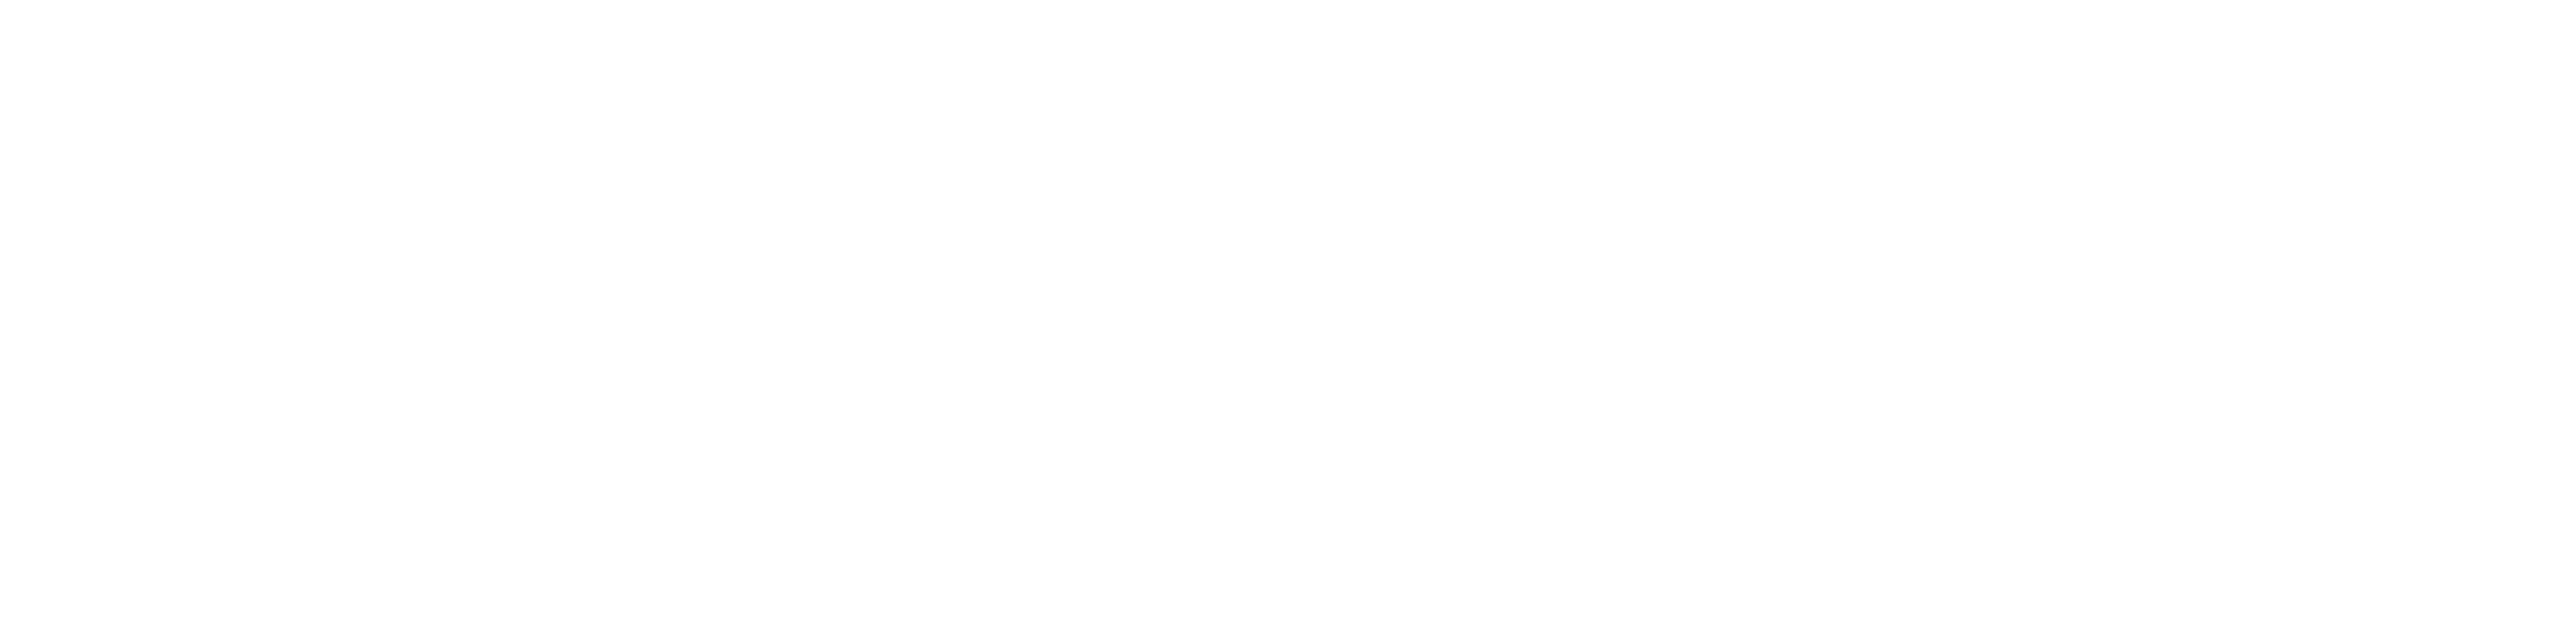

2020-06-04 01:09:42,340 logger INFO loss 2.93, 3D Dis:  5.38mm, shiftDiff: 36285.468750, MemUsed:50.86
2020-06-04 01:09:48,672 logger INFO loss 2.93, 3D Dis:  5.38mm, shiftDiff: 36277.347656, MemUsed:50.86
2020-06-04 01:09:55,066 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36272.171875, MemUsed:50.86
2020-06-04 01:10:01,345 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36266.453125, MemUsed:50.86
2020-06-04 01:10:07,963 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36258.773438, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


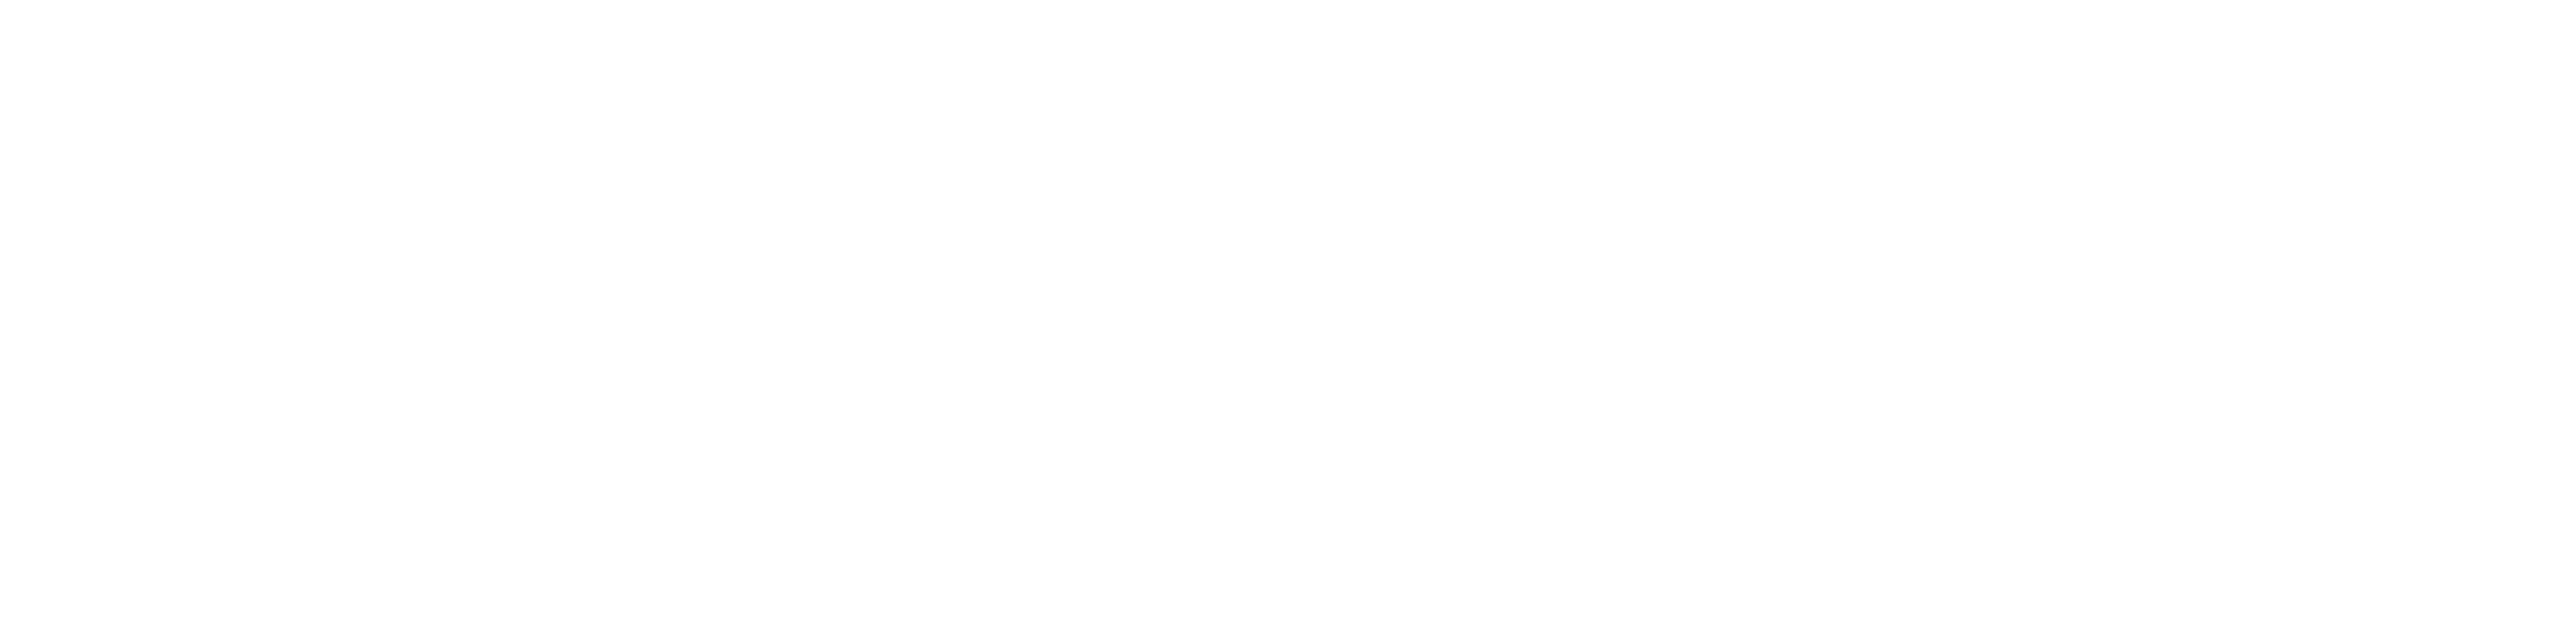

2020-06-04 01:10:32,423 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36251.269531, MemUsed:50.86
2020-06-04 01:10:38,847 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36245.308594, MemUsed:50.86
2020-06-04 01:10:45,194 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36240.289062, MemUsed:50.86
2020-06-04 01:10:51,792 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36236.414062, MemUsed:50.86
2020-06-04 01:10:58,298 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36232.179688, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


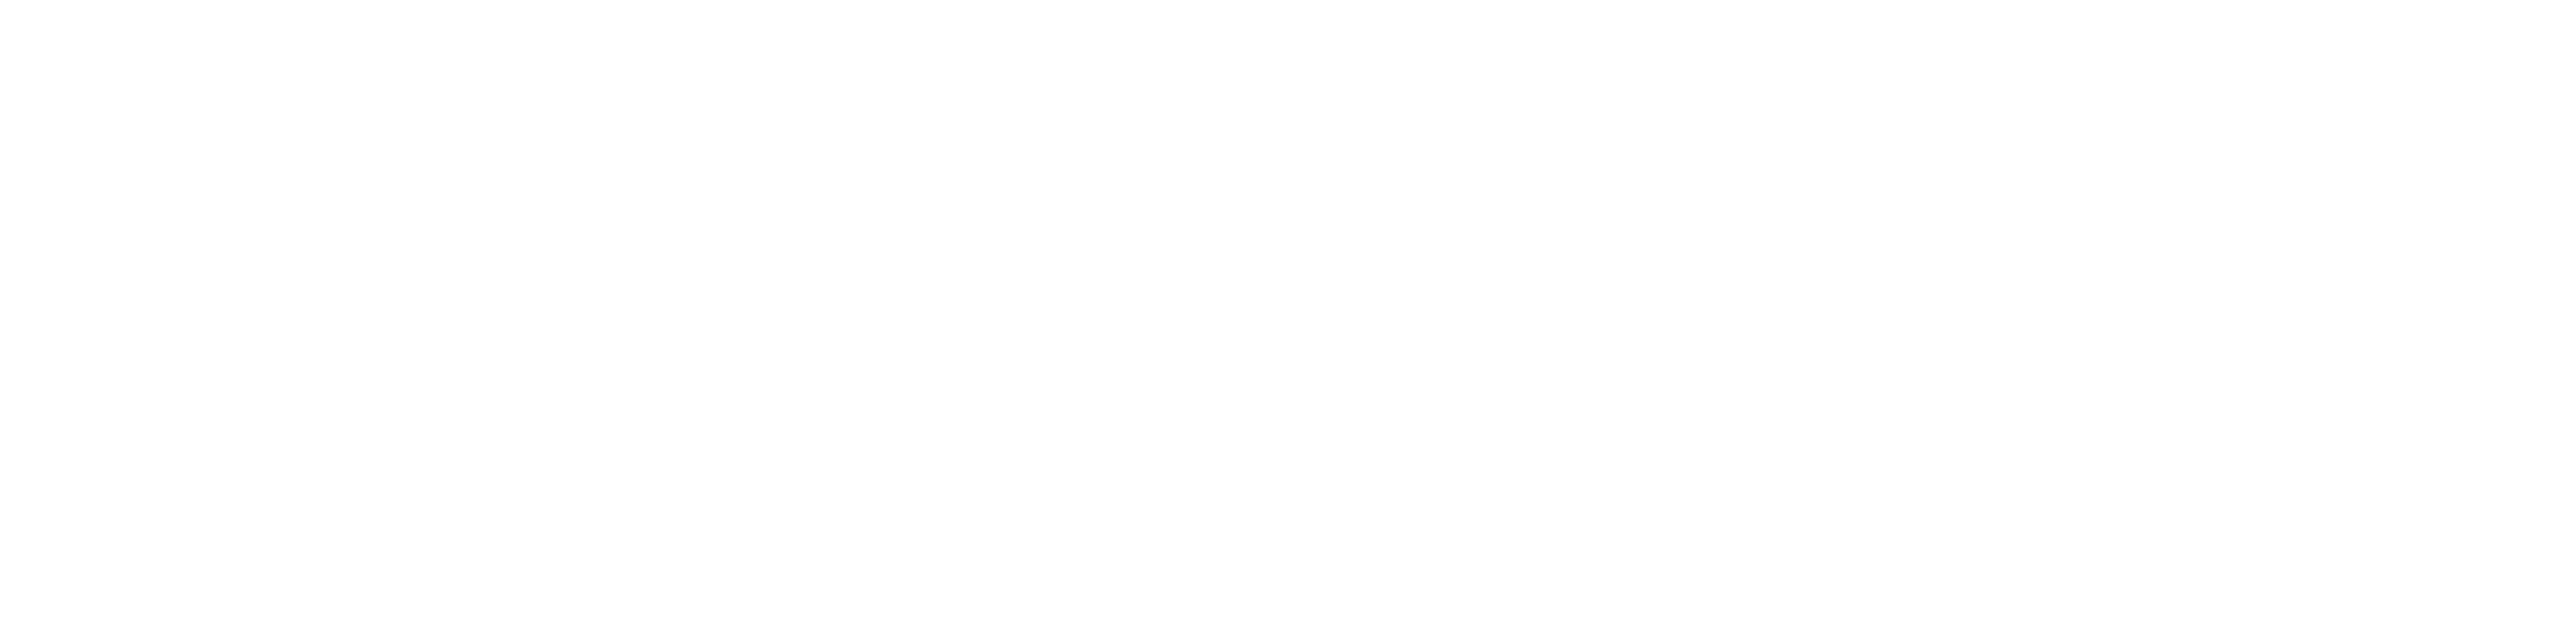

2020-06-04 01:11:22,905 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36227.437500, MemUsed:50.86
2020-06-04 01:11:29,215 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36223.164062, MemUsed:50.86
2020-06-04 01:11:35,610 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36218.710938, MemUsed:50.86
2020-06-04 01:11:42,087 logger INFO loss 2.93, 3D Dis:  5.37mm, shiftDiff: 36212.828125, MemUsed:50.86
2020-06-04 01:11:48,562 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36207.214844, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


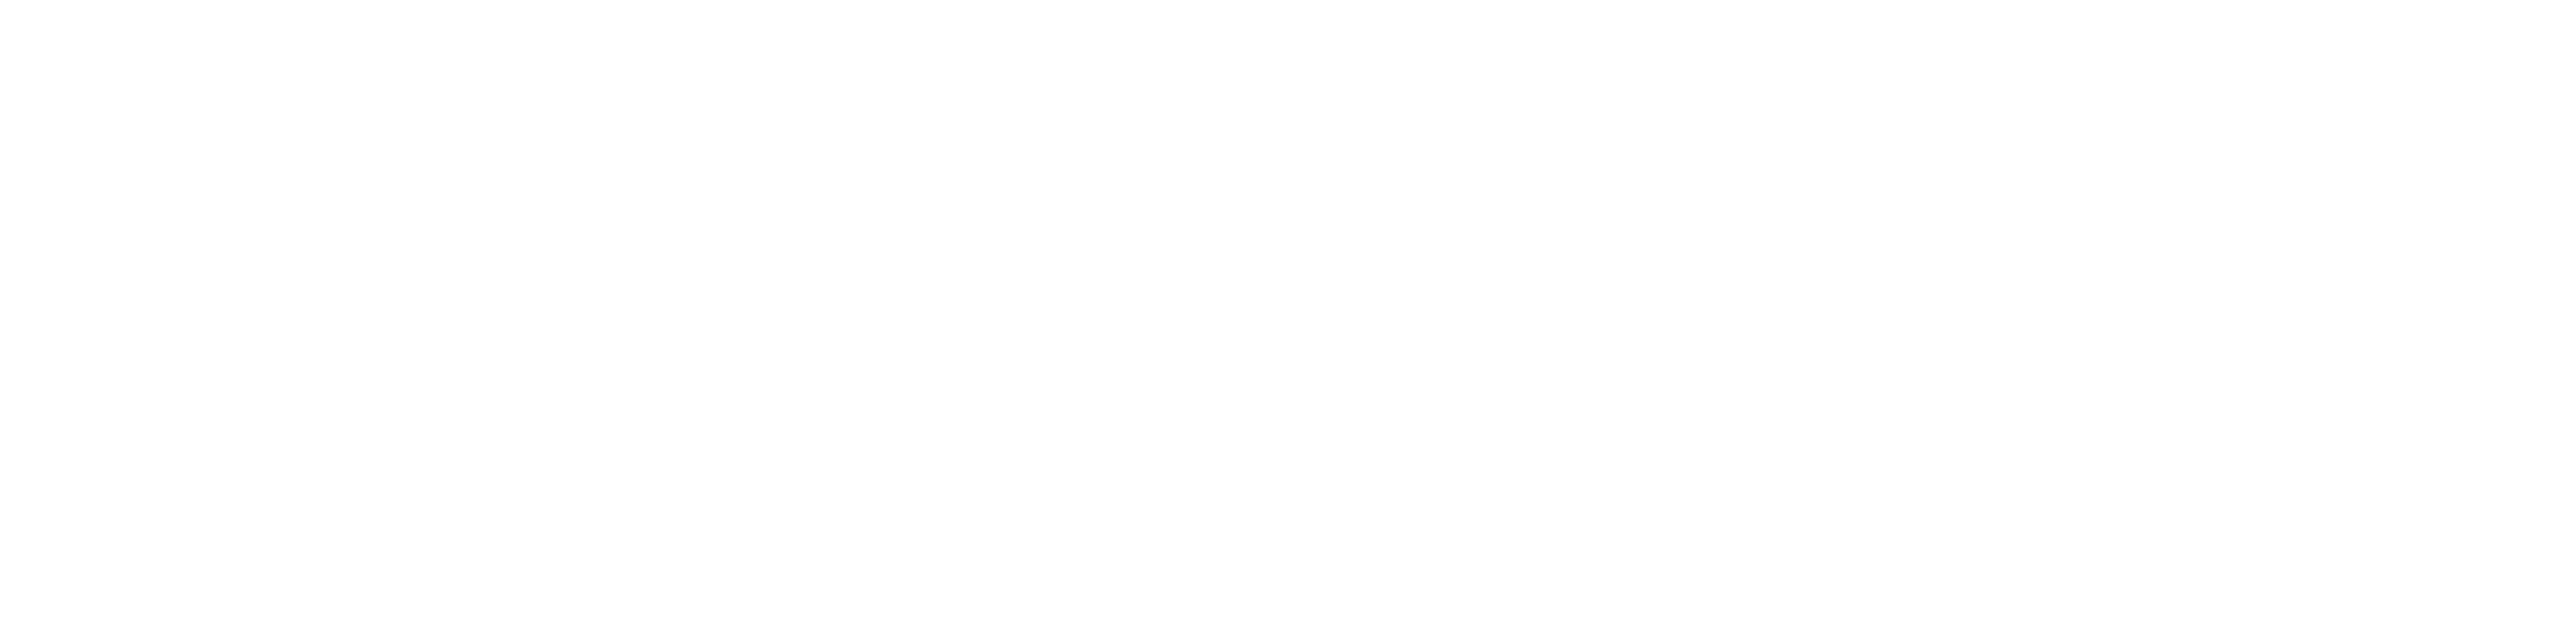

2020-06-04 01:12:13,096 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36202.199219, MemUsed:50.86
2020-06-04 01:12:19,491 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36195.707031, MemUsed:50.86
2020-06-04 01:12:25,912 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36187.347656, MemUsed:50.86
2020-06-04 01:12:32,338 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36181.484375, MemUsed:50.86
2020-06-04 01:12:38,846 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36175.515625, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


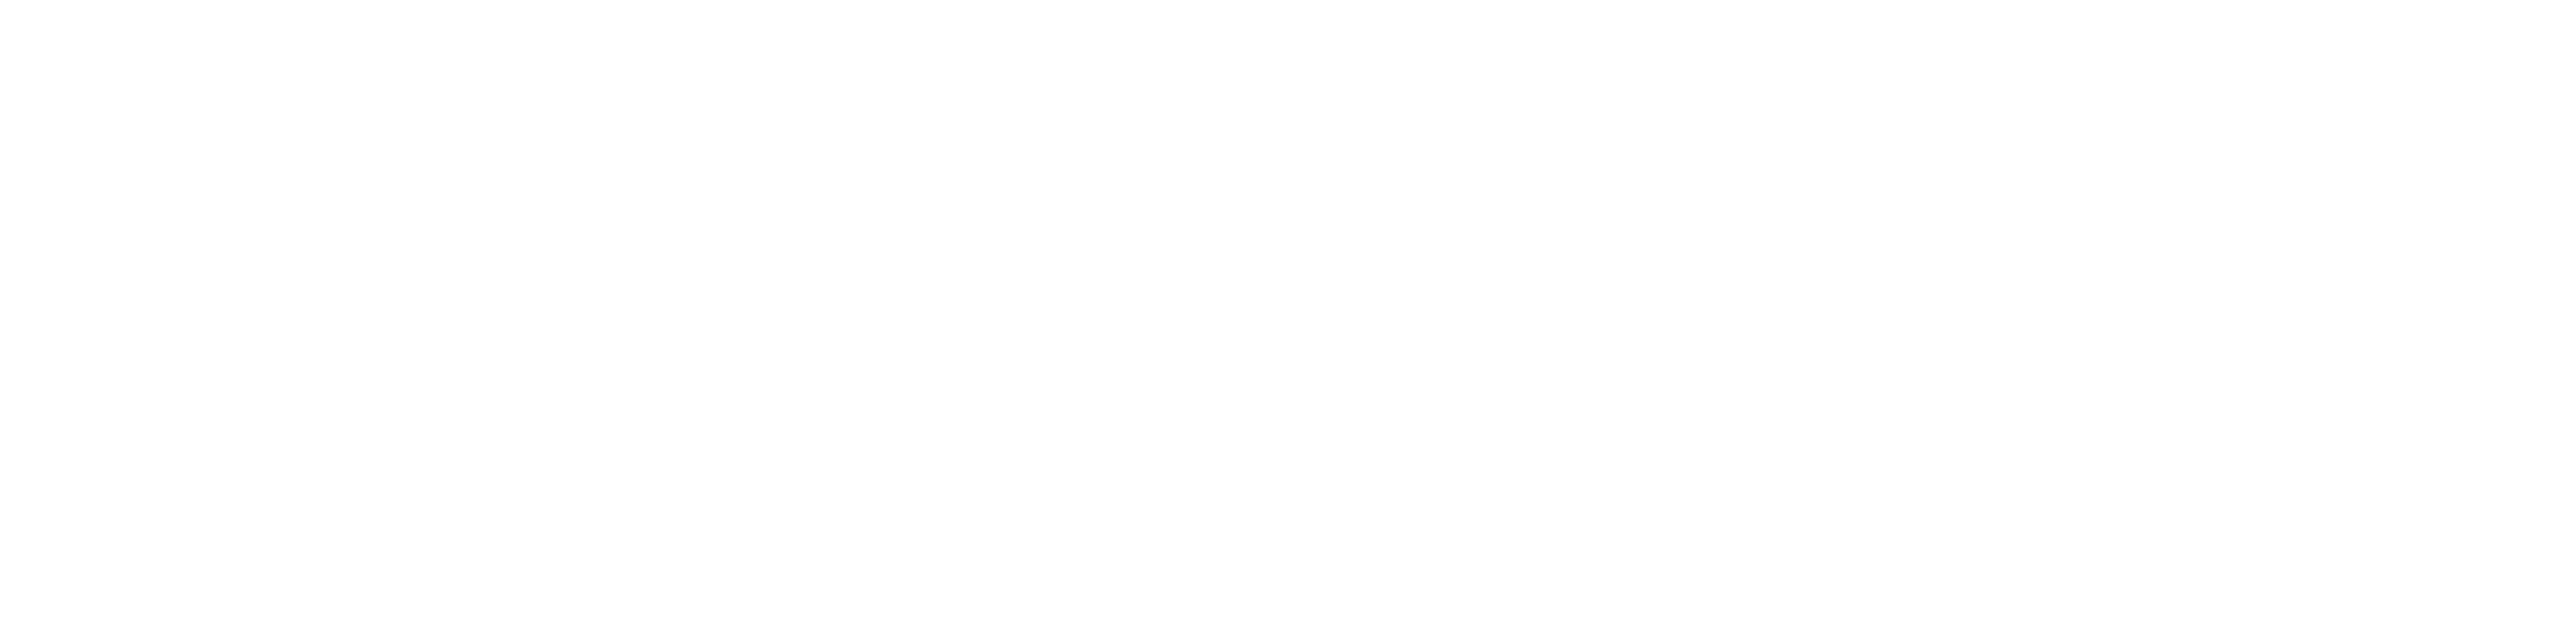

2020-06-04 01:13:03,440 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36169.394531, MemUsed:50.86
2020-06-04 01:13:09,772 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36164.378906, MemUsed:50.86
2020-06-04 01:13:16,210 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36159.671875, MemUsed:50.86
2020-06-04 01:13:22,696 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36155.261719, MemUsed:50.86
2020-06-04 01:13:29,272 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36153.332031, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


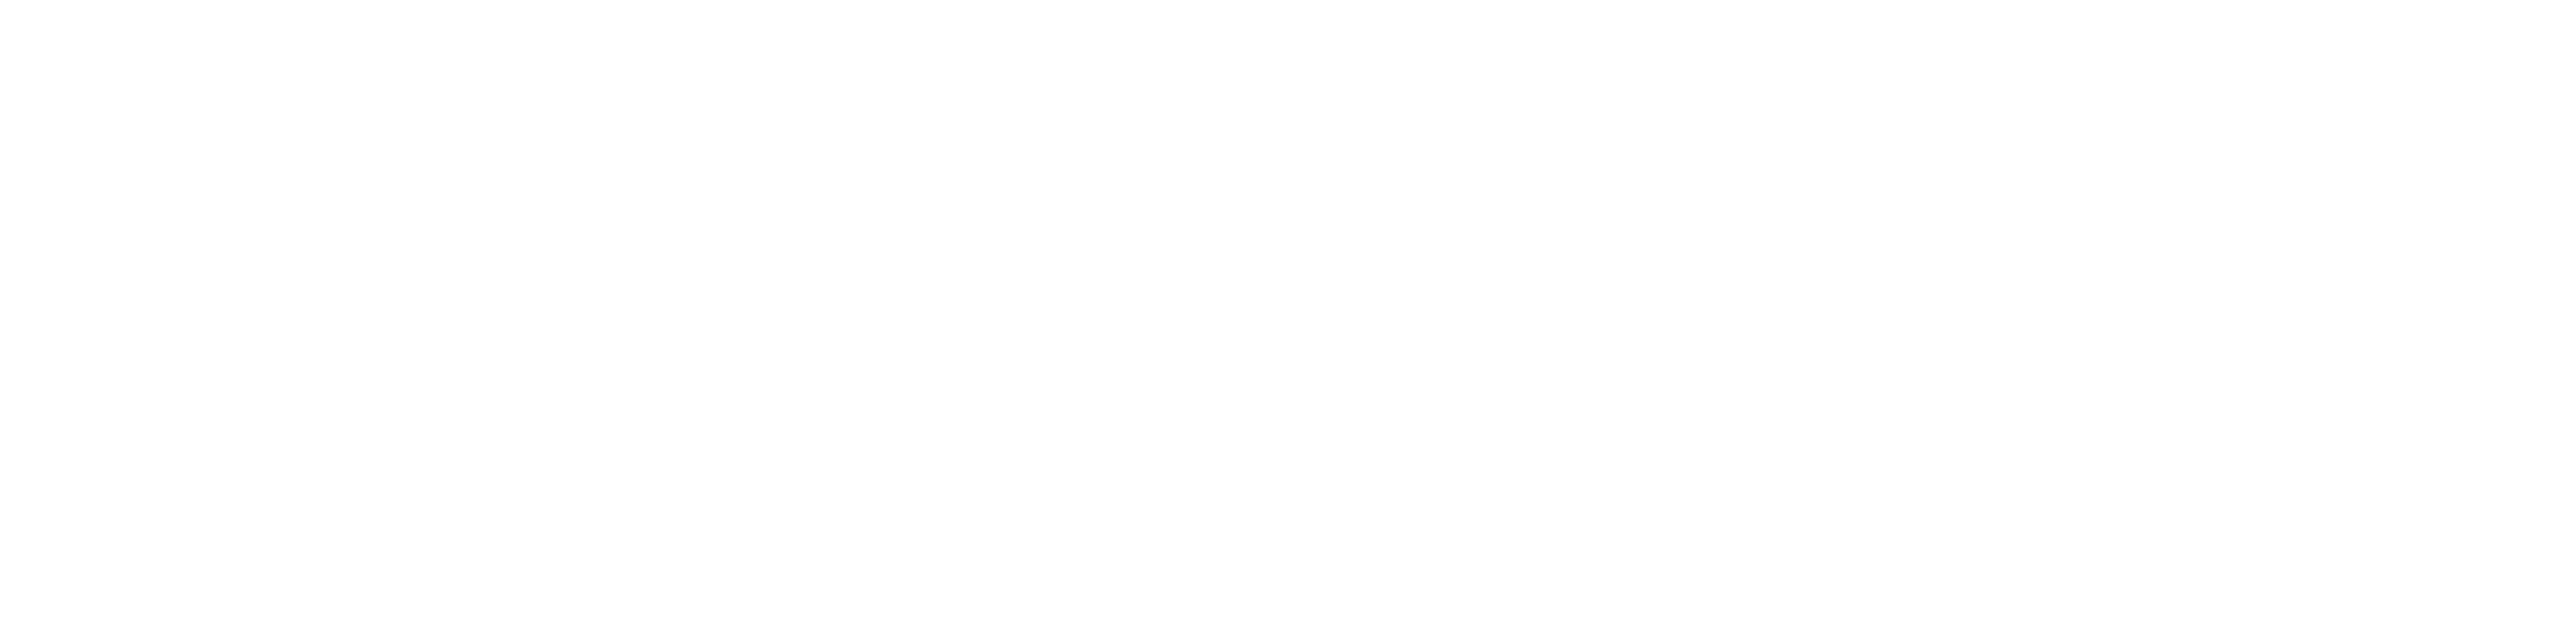

2020-06-04 01:13:53,840 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36150.984375, MemUsed:50.86
2020-06-04 01:14:00,155 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36149.726562, MemUsed:50.86
2020-06-04 01:14:06,539 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36147.550781, MemUsed:50.86
2020-06-04 01:14:13,076 logger INFO loss 2.93, 3D Dis:  5.36mm, shiftDiff: 36143.507812, MemUsed:50.86
2020-06-04 01:14:19,628 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36138.570312, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


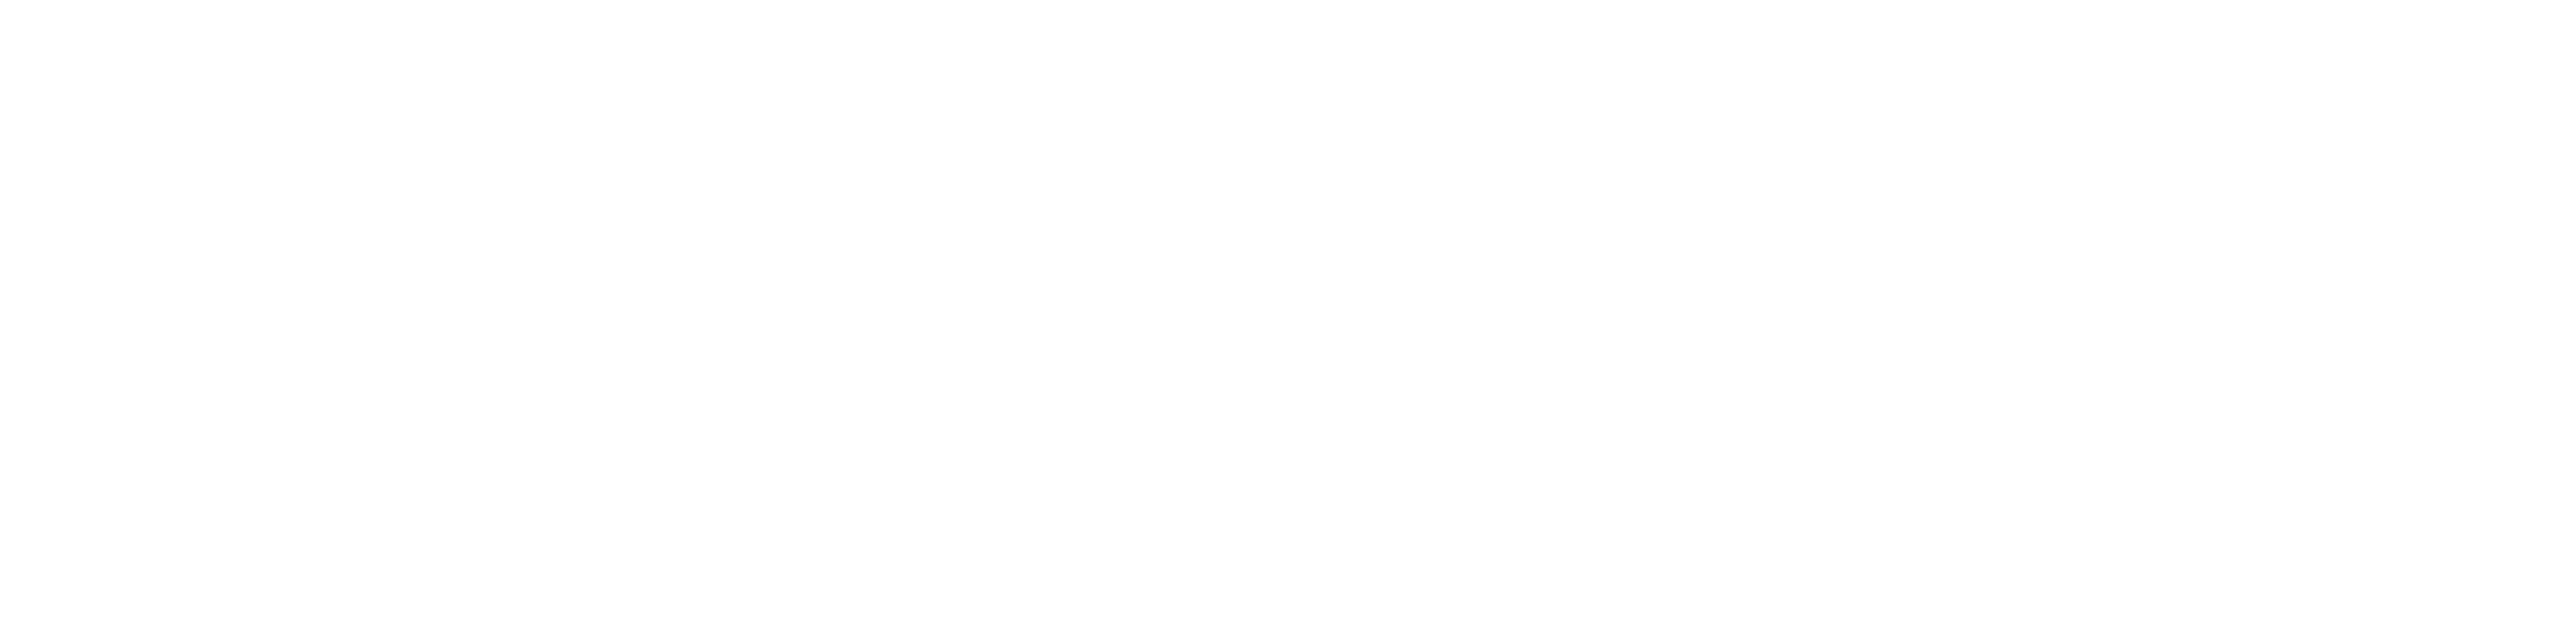

2020-06-04 01:14:44,230 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36134.734375, MemUsed:50.86
2020-06-04 01:14:50,562 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36131.570312, MemUsed:50.86
2020-06-04 01:14:56,896 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36127.679688, MemUsed:50.86
2020-06-04 01:15:03,487 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36122.187500, MemUsed:50.86
2020-06-04 01:15:09,995 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36114.773438, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


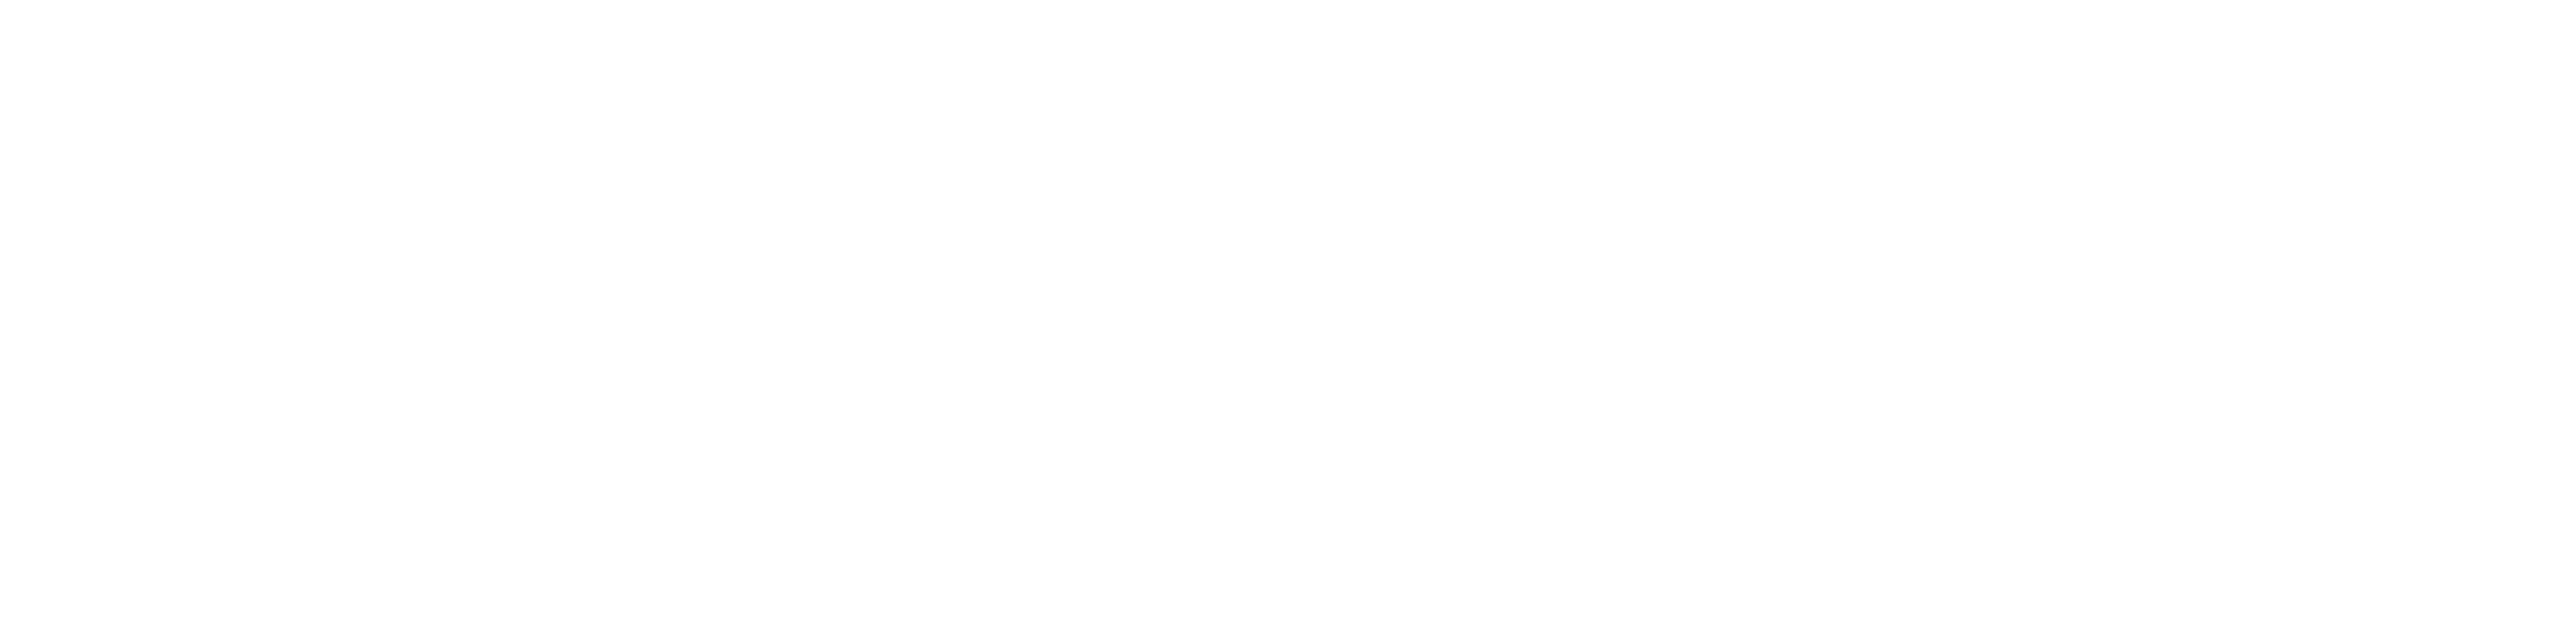

2020-06-04 01:15:34,566 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36107.308594, MemUsed:50.86
2020-06-04 01:15:40,881 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36101.445312, MemUsed:50.86
2020-06-04 01:15:47,309 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36096.070312, MemUsed:50.86
2020-06-04 01:15:53,741 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36092.273438, MemUsed:50.86
2020-06-04 01:16:00,195 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36086.125000, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


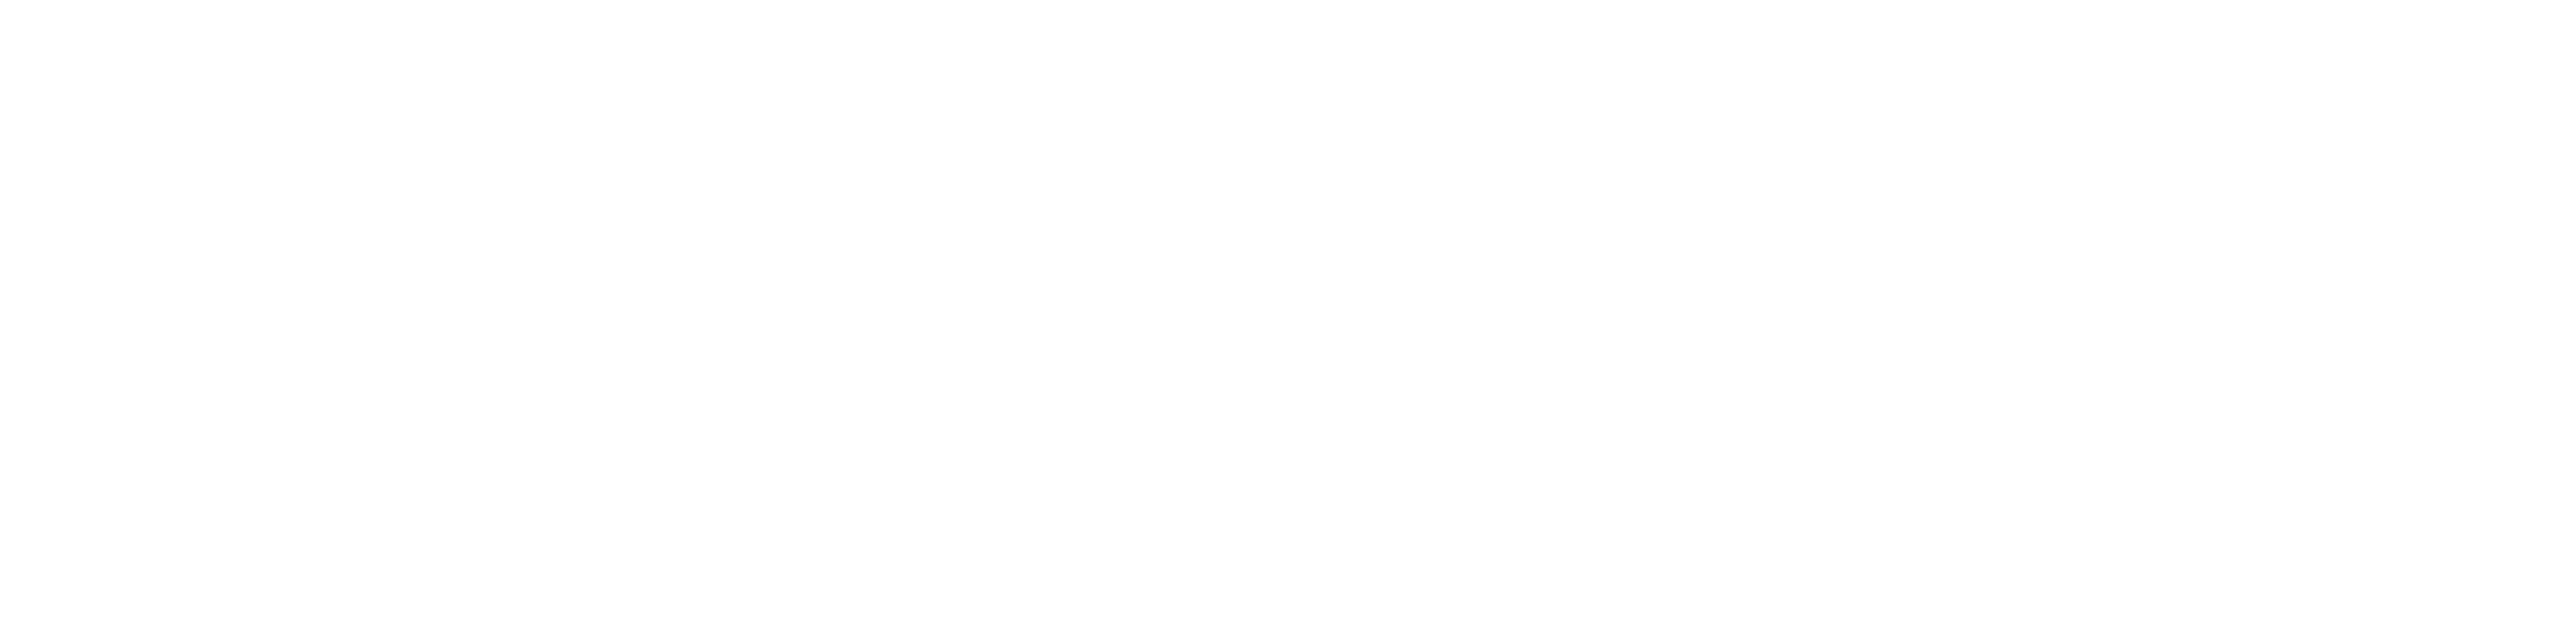

2020-06-04 01:16:24,788 logger INFO loss 2.93, 3D Dis:  5.35mm, shiftDiff: 36077.812500, MemUsed:50.86
2020-06-04 01:16:31,194 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36071.468750, MemUsed:50.86
2020-06-04 01:16:37,524 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36065.273438, MemUsed:50.86
2020-06-04 01:16:44,048 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36059.855469, MemUsed:50.86
2020-06-04 01:16:50,544 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36054.218750, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


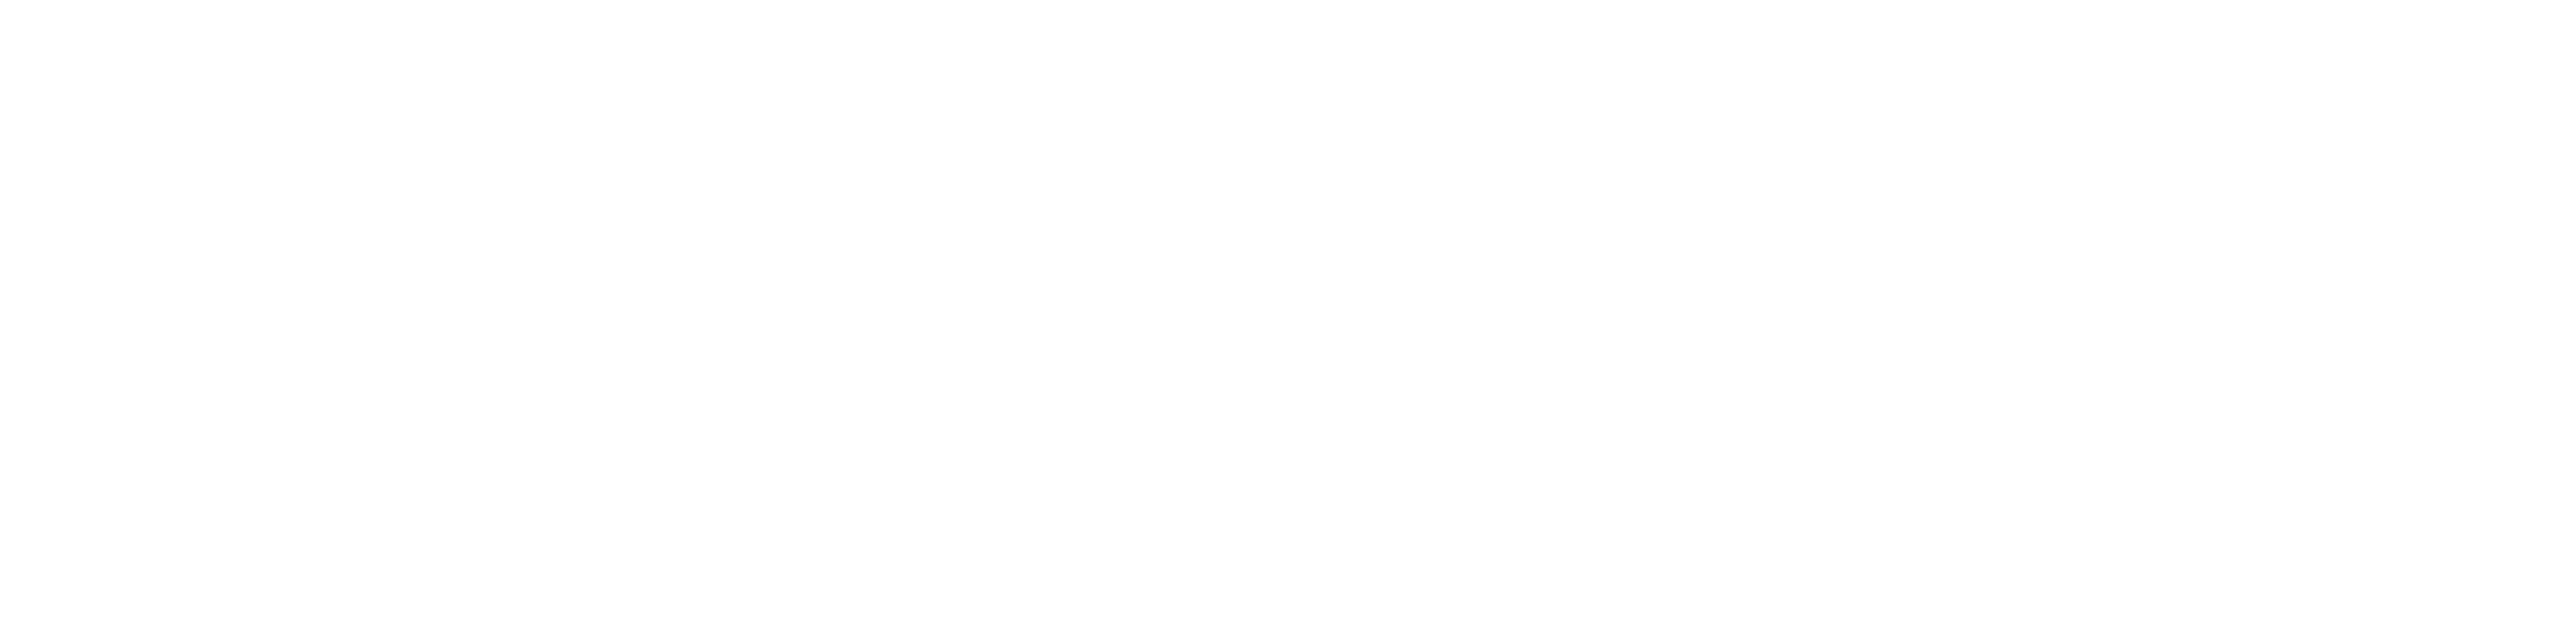

2020-06-04 01:17:15,137 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36047.062500, MemUsed:50.86
2020-06-04 01:17:21,468 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36042.718750, MemUsed:50.86
2020-06-04 01:17:27,860 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36037.343750, MemUsed:50.86
2020-06-04 01:17:34,248 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36033.164062, MemUsed:50.86
2020-06-04 01:17:40,785 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36030.335938, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


<IPython.core.display.Javascript object>


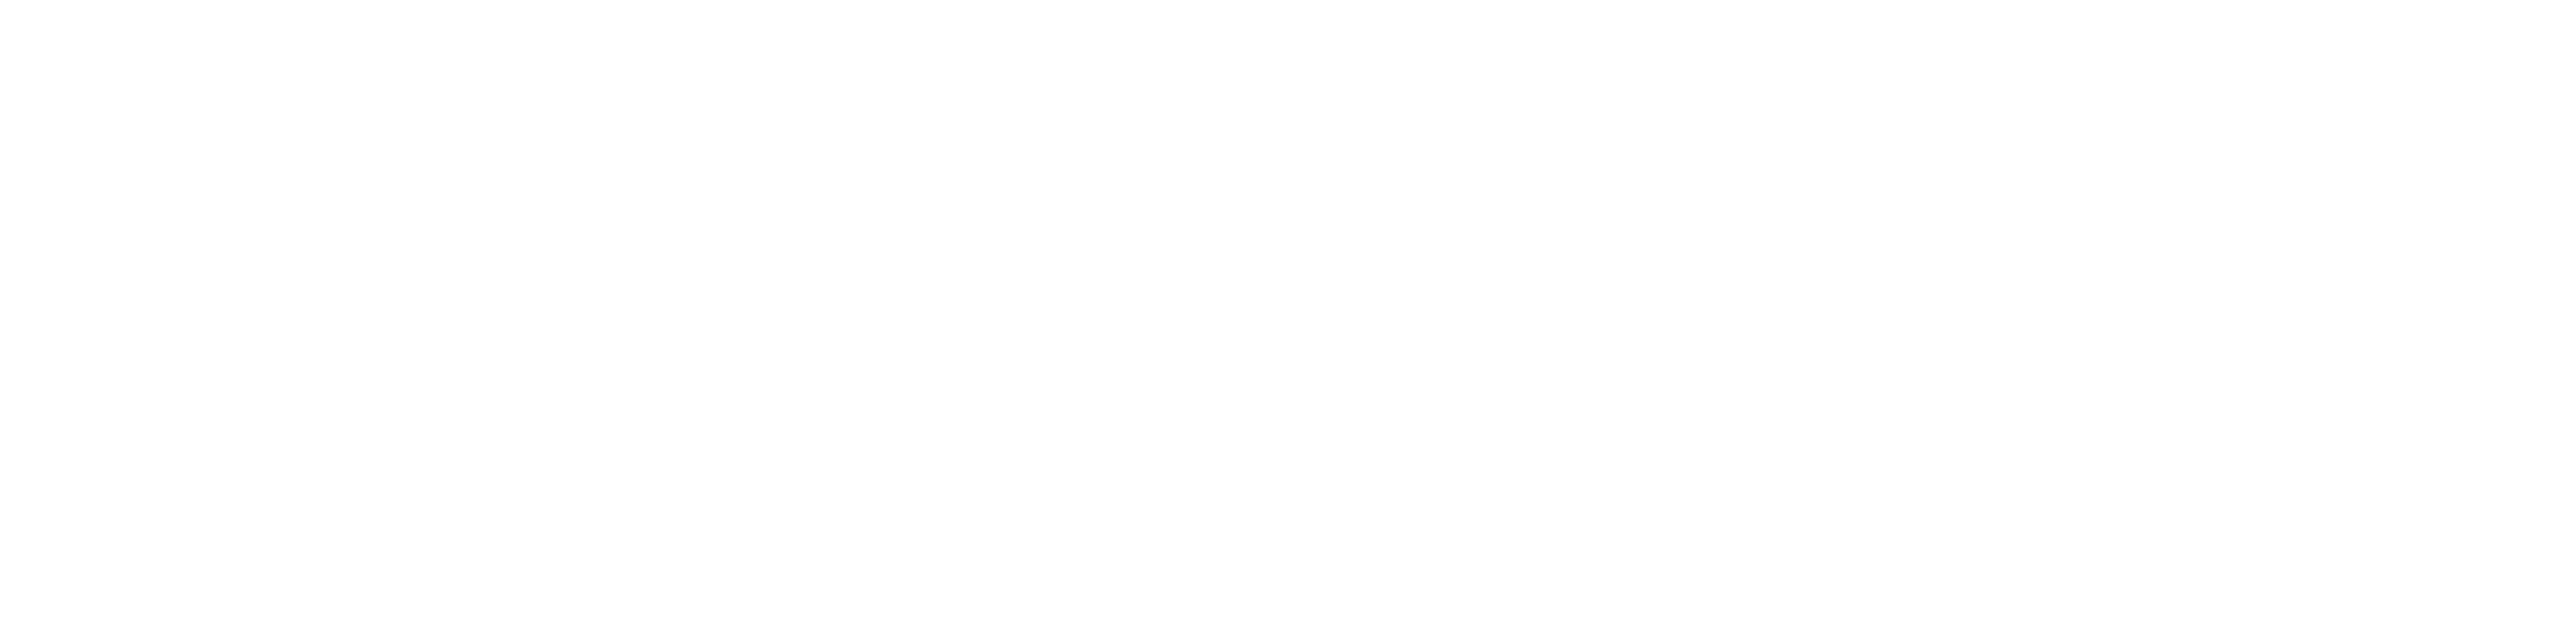

2020-06-04 01:18:05,299 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36029.125000, MemUsed:50.86
2020-06-04 01:18:11,756 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36028.191406, MemUsed:50.86
2020-06-04 01:18:18,197 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36026.945312, MemUsed:50.86
2020-06-04 01:18:24,634 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36027.000000, MemUsed:50.86
2020-06-04 01:18:31,040 logger INFO loss 2.93, 3D Dis:  5.34mm, shiftDiff: 36026.984375, MemUsed:50.86
Before release: active_bytes.all.current: 50.863616 MB
After release: active_bytes.all.current: 50.863616 MB


In [ ]:
cfg.numIterations = 300
loop = tqdm_notebook(range(cfg.numIterations))
saveVTK(join(outFolderMesh, 'Target.vtk'), modifiedVertsRef.cpu().detach().numpy(), smplshExampleMesh)
for i in loop:
    optimizer.zero_grad()
#     torch.cuda.empty_cache()

    lossVal = 0
    for iCam in range(cfg.numCams):
        refImg = torch.tensor(imagesRef[iCam][..., 3], dtype=torch.float64, device=device, requires_grad=False)
        modifiedVerts = verts + normalShift * nNormals
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        images = renderSynth.renderer(mesh, cameras=cams[iCam])
#         print(images.requires_grad)
#         print(modifiedVerts.requires_grad)
        loss = 1 - torch.norm(refImg * images[..., 3], p=1) / torch.norm(refImg + images[..., 3] - refImg * images[..., 3], p=1)
        
        loss.backward()
        lossVal += loss.item()
        #showCudaMemUsage(device)
    
    modifiedVerts = verts + normalShift * nNormals
    mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
    loss = cfg.lpSmootherW * mesh_laplacian_smoothing(mesh) + cfg.normalSmootherW * mesh_normal_consistency(mesh)
    loss.backward()
    lossVal += loss.item()
    # targetImg = images[0, ..., :3]
    # loss, _ = model()
    
    # recordData
    losses.append(lossVal)
    
    optimizer.step()
    memStats = torch.cuda.memory_stats(device=device)
    memAllocated =  memStats['active_bytes.all.current'] / 1000000
    torch.cuda.empty_cache()

    dis3D = modifiedVerts.cpu().detach().numpy() - modifiedVertsRef.cpu().numpy()
    dis3D = np.mean(np.sqrt(dis3D[:,0]**2 + dis3D[:,1]**2 + dis3D[:,2]**2))
    
    infoStr = 'loss %.2f, 3D Dis:  %.2fmm, shiftDiff: %.6f, MemUsed:%.2f' \
        % (lossVal, dis3D, torch.sum(torch.abs(normalShift - cfg.normalShiftLevel)).item(), memAllocated)
    
    loop.set_description(infoStr)
    logger.info(infoStr)
    
    #if lossVal < cfg.terminateLoss:
    #    break
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0:
        showCudaMemUsage(device)
        modifiedVerts = verts + normalShift * nNormals
        mesh = Meshes(
                verts=[modifiedVerts],   
                faces=[faces_idx], 
#                 textures=textures.to(device)
            )
        
        torch.cuda.empty_cache()
        plt.close('all')
        
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        diffImages = []
        with torch.no_grad():
            for iCam in range(len(cams)):
                image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
#                 images.append(image_cur.cpu().detach().numpy())
                imgDiff = np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
                diffImages.append(imgDiff)
                torch.cuda.empty_cache()

#             showCudaMemUsage(device)
        visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
        
        saveVTK(join(outFolderMesh, 'Fit' + str(i).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)


In [ ]:
diffImages[0].shape

In [ ]:
np.max(diffImages[0])

In [ ]:
if True:
    showCudaMemUsage(device)
    modifiedVerts = verts + normalShift * nNormals
    mesh = Meshes(
            verts=[modifiedVerts],   
            faces=[faces_idx], 
        )
    
    torch.cuda.empty_cache()
    plt.close('all')
    
    outImgFile = join(outFolderForExperiment, 'Fig_' + str(0).zfill(5) + '.png')
    diffImages = []
    with torch.no_grad():
        for iCam in range(len(cams)):
            image_cur = renderSynth.renderer(mesh,  cameras=cams[iCam])
            imgDiff =  np.abs(image_cur.cpu().detach().numpy() - imagesRef[iCam])
            diffImages.append(imgDiff)
    visualize2DResults(diffImages, outImgFile=outImgFile, sizeInInches=5)
    
    saveVTK(join(outFolderMesh, 'Fit' + str(0).zfill(5) + '.vtk'), modifiedVerts.cpu().detach().numpy(), smplshExampleMesh)